## CBC [ Study , Analysis , Detection ]
<img src="binary.png" alt="Drawing" width="4000"/>


# 1 . 1  Load and Explore the Data

In [2]:
#  Environment preparation
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
!cd NHANES
!pwd

/bin/bash: line 1: cd: NHANES: No such file or directory
/home/tallawi/CBC _model/NHANES


In [4]:

# قم بتحديد مسار الملفات إذا لزم الأمر
file_paths = [f'cbc{i}.XPT' for i in range(1, 14)]

# قراءة كل ملف وعرض معلوماته
all_data = []
for file in file_paths:
    df = pd.read_sas(file, format='xport')  # قراءة الملف بصيغة xpt
    print(f'Info for {file}:')
    print(df.info())  # عرض معلومات الملف
    print('========================================')


Info for cbc1.XPT:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8727 entries, 0 to 8726
Data columns (total 23 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEQN      8727 non-null   float64
 1   WTPH2YR   8727 non-null   float64
 2   LBXWBCSI  7593 non-null   float64
 3   LBXLYPCT  7582 non-null   float64
 4   LBXMOPCT  7582 non-null   float64
 5   LBXNEPCT  7582 non-null   float64
 6   LBXEOPCT  7582 non-null   float64
 7   LBXBAPCT  7582 non-null   float64
 8   LBDLYMNO  7582 non-null   float64
 9   LBDMONO   7582 non-null   float64
 10  LBDNENO   7582 non-null   float64
 11  LBDEONO   7582 non-null   float64
 12  LBDBANO   7582 non-null   float64
 13  LBXRBCSI  7593 non-null   float64
 14  LBXHGB    7593 non-null   float64
 15  LBXHCT    7593 non-null   float64
 16  LBXMCVSI  7593 non-null   float64
 17  LBXMC     7593 non-null   float64
 18  LBXMCHSI  7593 non-null   float64
 19  LBXRDW    7593 non-null   float64
 20  LBXPLTSI  7

## 1.2  comment  : 
     #       Combined data columns: Index(['SEQN', 'WTPH2YR', 'LBXWBCSI', 'LBXLYPCT', 'LBXMOPCT', 'LBXNEPCT',
      #  'LBXEOPCT', 'LBXBAPCT', 'LBDLYMNO', 'LBDMONO', 'LBDNENO', 'LBDEONO',
      #  'LBDBANO', 'LBXRBCSI', 'LBXHGB', 'LBXHCT', 'LBXMCVSI', 'LBXMC',
      #  'LBXMCHSI', 'LBXRDW', 'LBXPLTSI', 'LBXMPSI', 'LBXNRBC', 'LB2DAY',
      #  'LB2WBCSI', 'LB2LYPCT', 'LB2MOPCT', 'LB2NEPCT', 'LB2EOPCT', 'LB2BAPCT',
      #  'LB2LYMNO', 'LB2MONO', 'LB2NENO', 'LB2EONO', 'LB2BANO', 'LB2RBCSI',
      #  'LB2HGB', 'LB2HCT', 'LB2MCVSI', 'LB2MCHSI', 'LB2MC', 'LB2RDW',
      #  'LB2PLTSI', 'LB2MPSI'],
      # dtype='object')
            **WE NEED TO  Handle special case for file 3 (rename LB2* columns to LBX*)**

## 2 . preparing and cleaning

### 2 . 1  merge all files

In [6]:
from pathlib import Path

def merge_cbc_files(file_pattern='cbc*.XPT'):
    """
    Merge multiple CBC XPT files into a single DataFrame.
    
    Args:
        file_pattern (str): Pattern to match XPT files (default: 'cbc*.XPT')
        
    Returns:
        pandas.DataFrame: Merged data from all CBC files
    """
    # Store all dataframes
    dfs = []
    
    # Process each XPT file
    for file_path in sorted(Path('.').glob(file_pattern)):
        try:
            # Read the XPT file
            df = pd.read_sas(file_path)
            
            # Add file source
            df['source_file'] = file_path.name

 # Handle special case for file 3 (rename LB2* columns to LBX*)
            if 'LB2WBCSI' in df.columns:
                rename_dict = {
                    'LB2WBCSI': 'LBXWBCSI',
                    'LB2LYPCT': 'LBXLYPCT',
                    'LB2MOPCT': 'LBXMOPCT',
                    'LB2NEPCT': 'LBXNEPCT',
                    'LB2EOPCT': 'LBXEOPCT',
                    'LB2BAPCT': 'LBXBAPCT',
                    'LB2LYMNO': 'LBDLYMNO',
                    'LB2MONO': 'LBDMONO',
                    'LB2NENO': 'LBDNENO',
                    'LB2EONO': 'LBDEONO',
                    'LB2BANO': 'LBDBANO',
                    'LB2RBCSI': 'LBXRBCSI',
                    'LB2HGB': 'LBXHGB',
                    'LB2HCT': 'LBXHCT',
                    'LB2MCVSI': 'LBXMCVSI',
                    'LB2MCHSI': 'LBXMCHSI',
                    'LB2MC': 'LBXMC',
                    'LB2RDW': 'LBXRDW',
                    'LB2PLTSI': 'LBXPLTSI',
                    'LB2MPSI': 'LBXMPSI'
                }
                df = df.rename(columns=rename_dict)
            
            dfs.append(df)
            print(f"Processed {file_path.name}: {len(df)} rows")
            
        except Exception as e:
            print(f"Error processing {file_path.name}: {str(e)}")
    
    # Combine all dataframes
    merged_df = pd.concat(dfs, ignore_index=True)
    
    # Sort by SEQN
    merged_df = merged_df.sort_values('SEQN')
    
    return merged_df

def save_and_analyze(df, output_file='merged_cbc_data.csv'):
    """
    Save merged data and print analysis summary.
    
    Args:
        df (pandas.DataFrame): Merged DataFrame
        output_file (str): Output CSV filename
    """
    # Save to CSV
    df.to_csv(output_file, index=False)
    
    # Print summary
    print("\nMerged Data Summary:")
    print(f"Total rows: {len(df):,}")
    print(f"Total unique subjects (SEQN): {df['SEQN'].nunique():,}")
    print("\nColumns and non-null counts:")
    for col in df.columns:
        non_null = df[col].count()
        pct_non_null = (non_null / len(df)) * 100
        print(f"{col}: {non_null:,} ({pct_non_null:.1f}%)")

# Main execution
if __name__ == "__main__":
    try:
        # Merge files
        print("Starting CBC files merge...")
        merged_data = merge_cbc_files()
        
        # Save and analyze results
        save_and_analyze(merged_data)
        
        print("\nMerge completed successfully!")
        
    except Exception as e:
        print(f"An error occurred: {str(e)}")

Starting CBC files merge...
Processed cbc1.XPT: 8727 rows
Processed cbc10.XPT: 9440 rows
Processed cbc11.XPT: 8832 rows
Processed cbc12.XPT: 9307 rows
Processed cbc13.XPT: 8366 rows
Processed cbc2.XPT: 13772 rows
Processed cbc3.XPT: 557 rows
Processed cbc4.XPT: 9165 rows
Processed cbc5.XPT: 9422 rows
Processed cbc6.XPT: 8956 rows
Processed cbc7.XPT: 9835 rows
Processed cbc8.XPT: 9929 rows
Processed cbc9.XPT: 9179 rows

Merged Data Summary:
Total rows: 115,487
Total unique subjects (SEQN): 114,930

Columns and non-null counts:
SEQN: 115,487 (100.0%)
WTPH2YR: 8,727 (7.6%)
LBXWBCSI: 103,223 (89.4%)
LBXLYPCT: 103,028 (89.2%)
LBXMOPCT: 103,028 (89.2%)
LBXNEPCT: 103,028 (89.2%)
LBXEOPCT: 103,028 (89.2%)
LBXBAPCT: 103,028 (89.2%)
LBDLYMNO: 103,025 (89.2%)
LBDMONO: 103,025 (89.2%)
LBDNENO: 103,025 (89.2%)
LBDEONO: 103,025 (89.2%)
LBDBANO: 103,025 (89.2%)
LBXRBCSI: 103,226 (89.4%)
LBXHGB: 103,226 (89.4%)
LBXHCT: 103,226 (89.4%)
LBXMCVSI: 103,226 (89.4%)
LBXMC: 103,256 (89.4%)
LBXMCHSI: 103,226 

## 2.2 optimize columns

In [8]:
df = merged_data.drop(['SEQN','WTPH2YR','LBXNRBC','source_file','LB2DAY'],axis=1)

In [10]:
# Mapping dictionary for renaming columns to shorter, similar names
column_mapping = {
    'LBXWBCSI': 'WBC',     # White Blood Cell Count
    'LBXLYPCT': 'LY%',     # Lymphocytes Percentage
    'LBXMOPCT': 'MO%',     # Monocytes Percentage
    'LBXNEPCT': 'NE%',     # Neutrophils Percentage
    'LBXEOPCT': 'EO%',     # Eosinophils Percentage
    'LBXBAPCT': 'BA%',     # Basophils Percentage
    'LBDLYMNO': 'LY#',     # Lymphocyte Count
    'LBDMONO': 'MO#',      # Monocyte Count
    'LBDNENO': 'NE#',      # Neutrophil Count
    'LBDEONO': 'EO#',      # Eosinophil Count
    'LBDBANO': 'BA#',      # Basophil Count
    'LBXRBCSI': 'RBC',     # Red Blood Cell Count
    'LBXHGB': 'HGB',       # Hemoglobin
    'LBXHCT': 'HCT',       # Hematocrit
    'LBXMCVSI': 'MCV',     # Mean Corpuscular Volume
    'LBXMCHSI': 'MCH',     # Mean Corpuscular Hemoglobin
    'LBXMC': 'MCHC',       # Mean Corpuscular Hemoglobin Concentration
    'LBXRDW': 'RDW',       # Red Cell Distribution Width
    'LBXPLTSI': 'PLT',     # Platelet Count
    'LBXMPSI': 'MPV',      # Mean Platelet Volume
}

# Apply renaming
df = df.rename(columns=column_mapping)

# Display the new column names to verify
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 115487 entries, 18167 to 8726
Data columns (total 20 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   WBC     103223 non-null  float64
 1   LY%     103028 non-null  float64
 2   MO%     103028 non-null  float64
 3   NE%     103028 non-null  float64
 4   EO%     103028 non-null  float64
 5   BA%     103028 non-null  float64
 6   LY#     103025 non-null  float64
 7   MO#     103025 non-null  float64
 8   NE#     103025 non-null  float64
 9   EO#     103025 non-null  float64
 10  BA#     103025 non-null  float64
 11  RBC     103226 non-null  float64
 12  HGB     103226 non-null  float64
 13  HCT     103226 non-null  float64
 14  MCV     103226 non-null  float64
 15  MCHC    103256 non-null  float64
 16  MCH     103226 non-null  float64
 17  RDW     103226 non-null  float64
 18  PLT     103224 non-null  float64
 19  MPV     103224 non-null  float64
dtypes: float64(20)
memory usage: 18.5 MB


In [12]:
df= df.drop_duplicates().dropna()

# 3 . E D A
## 3.1 Describe DataFrame of CBC

- **WBC, NE#, LY#, MO#, EO#, BA#** — *White Blood Cells*
- **RBC, HGB, HCT, MCV, MCH, MCHC** — *Red Blood Cells*
- **RDW, PLT, MPV, PCT, PDW** — *Platelets*



In [13]:
df_describe = df.describe()
df_describe

,WBC,LY%,MO%,NE%,EO%,BA%,LY#,MO#,NE#,EO#,BA#,RBC,HGB,HCT,MCV,MCHC,MCH,RDW,PLT,MPV
count,95501.000000,95501.000000,95501.000000,95501.000000,9.550100e+04,9.550100e+04,95501.000000,9.550100e+04,95501.000000,9.550100e+04,9.550100e+04,95501.000000,95501.000000,95501.000000,95501.000000,95501.000000,95501.000000,95501.000000,95501.000000,95501.000000
mean,7.267482,33.477743,8.045868,54.813060,3.013379e+00,7.126910e-01,2.385750,5.682401e-01,4.053332,2.150784e-01,4.355033e-02,4.676628,13.797030,40.726927,87.292241,33.863062,29.573944,13.139576,270.228037,8.060592
std,2.668051,10.637626,2.333030,11.627099,2.420814e+00,5.141226e-01,1.684634,2.060392e-01,1.769752,1.938372e-01,6.307146e-02,0.478841,1.503794,4.293492,6.267451,0.970965,2.440585,1.296097,74.300656,0.929793
min,1.400000,2.600000,0.600000,0.800000,5.397605e-79,5.397605e-79,0.200000,5.397605e-79,0.100000,5.397605e-79,5.397605e-79,1.670000,5.400000,16.300000,35.400000,25.100000,10.200000,6.300000,4.000000,4.700000
25%,5.700000,26.200000,6.500000,47.800000,1.500000e+00,4.000000e-01,1.700000,4.000000e-01,2.800000,1.000000e-01,5.397605e-79,4.360000,12.800000,37.700000,83.700000,33.300000,28.300000,12.300000,219.000000,7.400000
50%,6.900000,32.300000,7.800000,55.900000,2.300000e+00,6.000000e-01,2.200000,5.000000e-01,3.800000,2.000000e-01,5.397605e-79,4.660000,13.700000,40.500000,87.800000,33.900000,29.800000,12.900000,262.000000,8.000000
75%,8.400000,39.600000,9.300000,62.800000,3.700000e+00,9.000000e-01,2.800000,7.000000e-01,4.900000,3.000000e-01,1.000000e-01,4.980000,14.800000,43.700000,91.400000,34.500000,31.200000,13.600000,311.000000,8.600000
max,400.000000,94.500000,66.900000,96.600000,5.720000e+01,3.540000e+01,358.800000,1.020000e+01,83.100000,8.400000e+00,4.700000e+00,9.160000,19.900000,59.900000,125.300000,69.600000,74.500000,37.800000,1021.000000,15.100000


## 3.2 Splitting
 Split dataframe vertically based on features 

 ### Data Division Overview

- **Dataset**
  - **RBC Features**
    - RBC: Red Blood Cell Count
    - HGB: Hemoglobin Level
    - HCT: Hematocrit Percentage
    - MCV: Mean Corpuscular Volume
    - MCH: Mean Corpuscular Hemoglobin
    - MCHC: Mean Corpuscular Hemoglobin Concentration
    - RDW: Red Cell Distribution Width
    - PLT: Platelet Count

  - **WBC Features**
    - WBC: White Blood Cell Count
    - NE#: Neutrophil Count
    - LY#: Lymphocyte Count
    - MO#: Monocyte Count
    - EO#: Eosinophil Count
    - BA#: Basophil Count
    - NE%: Neutrophil Relative count
    - LY%: Lymphocyte Relative count
    - MO%: Monocyte Relative count
    - EO%: Eosinophil Relative count
    - BA%: Basophil Relative count
    - PLT: Platelet Count

  - **Platelet Features**
    - PLT: Platelet Count
    - MPV: Mean Platelet Volume


In [14]:
rbc_features = ['RBC','HGB','HCT','MCV','MCH','MCHC','RDW','PLT']
wbc_features = ['WBC','NE#','LY#','MO#','EO#','BA#','NE%','LY%','MO%','EO%','BA%','PLT']
plt_features = ['PLT','MPV']
df_rbc = df[rbc_features]
df_wbc = df[wbc_features]
df_plt = df[plt_features]

# 4. RBC <img src="rbc.png" alt="Smiley face" width="30" height="30" style="vertical-align:middle;margin:0px 50px">
## 4.1 Splitting data fram based on HGB ,RBC
 
### Data Splitting Overview

In this analysis, the data has been divided into multiple sections based on specific criteria related to blood measurements:

#### 1. **Primary Data Splitting**
The data has been initially divided into three main groups based on Hemoglobin (HGB) and Red Blood Cells (RBC) levels:

- **Anemia DataFrame (`df_anemia`)**: Contains records where:
  - HGB < 12.0 or RBC < 3.8 (indicating anemia).

- **Greater RBC DataFrame (`df_RBC_GREATER`)**: Contains records where:
  - HGB > 17.5 or RBC > 5.9 (indicating elevated levels).

- **Normal RBC DataFrame (`df_RBC_NORMAL`)**: Contains records with normal ranges:
  - HGB is within the interval [12.0, 17.5]
  - RBC is within the interval [3.8, 5.9]

#### 2. **Anemia Classification**
The `df_anemia` DataFrame is further classified into three types of anemia based on MCV (Mean Corpuscular Volume):

- **Microcytic Anemia**: MCV < 80
- **Normocytic Anemia**: 80 ≤ MCV ≤ 100
- **Macrocytic Anemia**: MCV > 100

This structured approach allows for a clearer analysis of the relationships between blood parameters and different types of anemia.



In [16]:

# Function to classify anemia based on MCV value
def classify_anemia(row):
    if row['MCV'] < 80:  # Microcytic
        return 'Microcytic'
    elif 80 <= row['MCV'] <= 100:  # Normocytic
        return 'Normocytic'
    elif row['MCV'] > 100:  # Macrocytic
        return 'Macrocytic'
    else:
        return 'Unknown'

# Splitting the data based on HGB and RBC values
df_anemia = df_rbc[(df_rbc['HGB'] < 12.0) | (df_rbc['RBC'] < 3.8)]


# Define normal ranges
hgb_normal_range = pd.Interval(left=12.0, right=17.5, closed='both')  # Adjust right value based on gender if needed
rbc_normal_range = pd.Interval(left=3.8, right=5.9, closed='both')

# Filter DataFrame based on normal ranges
df_RBC_NORMAL = df_rbc[
    df_rbc['HGB'].apply(lambda x: x in hgb_normal_range) & 
    df_rbc['RBC'].apply(lambda x: x in rbc_normal_range)
]

df_RBC_GREATER = df_rbc[
    ( df_rbc['HGB'].apply(lambda x: x in hgb_normal_range) &  (df_rbc['RBC'] >5.9) ) |
    ( df_rbc['RBC'].apply(lambda x: x in rbc_normal_range) &  (df_rbc['HGB'] > 17.5) ) |
    ((df_rbc['HGB'] > 17.5) & (df_rbc['RBC'] >5.9))
    
]


# Applying anemia classification to the df_anemia DataFrame
df_anemia['AnemiaType'] = df_anemia.apply(classify_anemia, axis=1)

# # Print results
# print("========================================= Anemia Data =========================================")
# display(df_anemia['AnemiaType'].value_counts())

# print("========================================= df_RBC_NORMAL Data =========================================")
# display(df_RBC_NORMAL.head())

# print("========================================= df_RBC_GREATER Data =========================================")
# display(df_RBC_GREATER.head())

# # Optional: Save these tables to CSV files if needed
# df_anemia.to_csv('anemia_data.csv', index=False)
# df_RBC_NORMAL.to_csv('df_RBC_NORMAL.csv', index=False)
# df_RBC_GREATER.to_csv('df_RBC_GREATER.csv', index=False)

/tmp/ipykernel_512213/1110735058.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_anemia['AnemiaType'] = df_anemia.apply(classify_anemia, axis=1)


In [18]:
display(df_anemia['AnemiaType'].value_counts())

AnemiaType
Normocytic    5638
Microcytic    3797
Macrocytic     365
Name: count, dtype: int64

## 4.2 Anemia
### 4.2.1 Splitting the dataframe **(`df_anemia`)** based on the type of anemia :
<p align="center">
<h3>- Microcytic Anemia</h3>
<h3>- Normocytic Anemia</h3>
<h3>- Macrocytic Anemia</h3>

  <img src="anemiatype.gif" width="700" height="100" style="vertical-align:middle;margin:0px 50px">
</p>

In [20]:

df_microcytic = df_anemia[df_anemia['AnemiaType'] == 'Microcytic']
df_normocytic = df_anemia[df_anemia['AnemiaType'] == 'Normocytic']
df_macrocytic = df_anemia[df_anemia['AnemiaType'] == 'Macrocytic']


## 4.2.1 describe Anemia Types : 

In [22]:

print( '========================================= All Anemia =========================================')
df_anemia.describe()
print( '========================================= Microcytic =========================================')
df_microcytic.describe()
print( '========================================= Normocytic =========================================')
df_normocytic.describe()
print( '========================================= Macrocytic =========================================')
df_macrocytic.describe()

========================================= All Anemia =========================================


,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT
count,9800.000000,9800.00000,9800.000000,9800.000000,9800.000000,9800.000000,9800.000000,9800.000000
mean,4.152285,11.27798,33.913653,82.675918,27.544214,33.237602,14.420704,294.219490
std,0.516173,0.88244,2.342228,9.781114,3.895259,1.350496,2.238062,93.353225
min,1.670000,5.40000,16.300000,35.400000,10.200000,25.100000,10.900000,13.000000
25%,3.780000,11.00000,33.000000,76.600000,25.200000,32.400000,12.900000,232.000000
50%,4.120000,11.50000,34.300000,82.300000,27.500000,33.300000,13.900000,285.000000
75%,4.450000,11.80000,35.400000,89.100000,29.900000,34.100000,15.400000,345.000000
max,7.170000,15.00000,42.800000,125.300000,74.500000,69.600000,37.500000,1000.000000


========================================= Microcytic =========================================


,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT
count,3797.000000,3797.000000,3797.000000,3797.000000,3797.000000,3797.000000,3797.000000,3797.000000
mean,4.594414,10.932262,33.509876,73.227785,23.908717,32.593679,15.506215,327.462997
std,0.435465,1.003447,2.648926,5.591583,2.415477,1.321894,2.517216,92.453352
min,2.740000,5.400000,19.700000,35.400000,10.200000,25.200000,11.000000,53.000000
25%,4.330000,10.600000,32.400000,70.000000,22.400000,31.700000,13.700000,265.000000
50%,4.540000,11.300000,34.000000,74.900000,24.500000,32.600000,15.000000,317.000000
75%,4.800000,11.600000,35.300000,77.600000,25.700000,33.500000,16.700000,377.000000
max,7.170000,11.900000,39.000000,79.900000,29.200000,37.000000,36.500000,818.000000


========================================= Normocytic =========================================


,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT
count,5638.000000,5638.000000,5638.000000,5638.00000,5638.000000,5638.000000,5638.000000,5638.000000
mean,3.901632,11.450337,34.068624,87.63017,29.461955,33.607237,13.710536,276.666903
std,0.316426,0.652792,1.949407,5.36469,2.236864,1.092160,1.674281,86.068833
min,1.710000,5.900000,16.300000,80.00000,21.300000,25.100000,10.900000,13.000000
25%,3.700000,11.200000,33.200000,83.00000,27.700000,32.900000,12.600000,219.000000
50%,3.920000,11.600000,34.400000,86.70000,29.000000,33.600000,13.400000,267.000000
75%,4.140000,11.800000,35.300000,91.70000,31.000000,34.300000,14.400000,323.000000
max,4.920000,15.000000,41.700000,100.00000,42.800000,44.200000,37.500000,1000.000000


========================================= Macrocytic =========================================


,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,3.424658,12.212055,35.720274,104.436164,35.740822,34.226575,14.098082,219.523288
std,0.318181,1.131913,3.211590,4.191240,2.815773,2.231820,2.267901,94.083769
min,1.670000,8.200000,17.900000,100.100000,32.300000,31.700000,11.200000,38.000000
25%,3.300000,11.600000,34.400000,101.500000,34.400000,33.300000,12.700000,164.000000
50%,3.490000,12.400000,36.400000,103.200000,35.300000,34.000000,13.600000,208.000000
75%,3.660000,12.900000,37.800000,106.100000,36.300000,34.700000,14.700000,263.000000
max,3.790000,14.900000,42.800000,125.300000,74.500000,69.600000,30.500000,1000.000000


<Figure size 800x600 with 0 Axes>

<Axes: xlabel='AnemiaType', ylabel='RBC'>

Text(0.5, 1.0, 'Violin Plot for RBC')

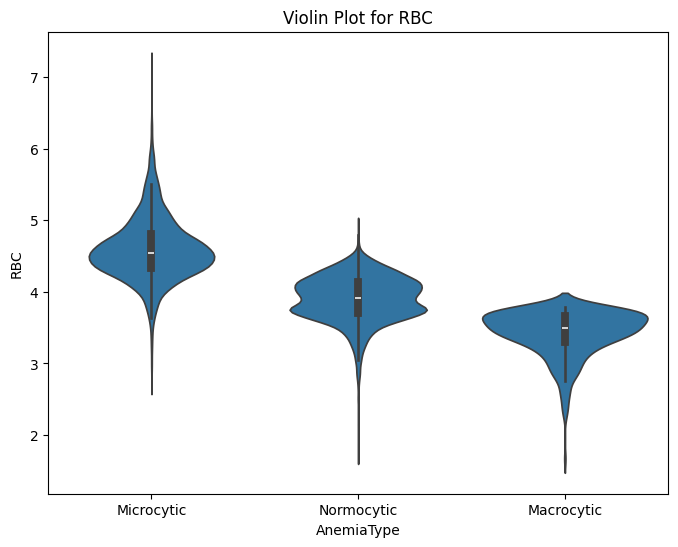

<Figure size 800x600 with 0 Axes>

<Axes: xlabel='AnemiaType', ylabel='HGB'>

Text(0.5, 1.0, 'Violin Plot for HGB')

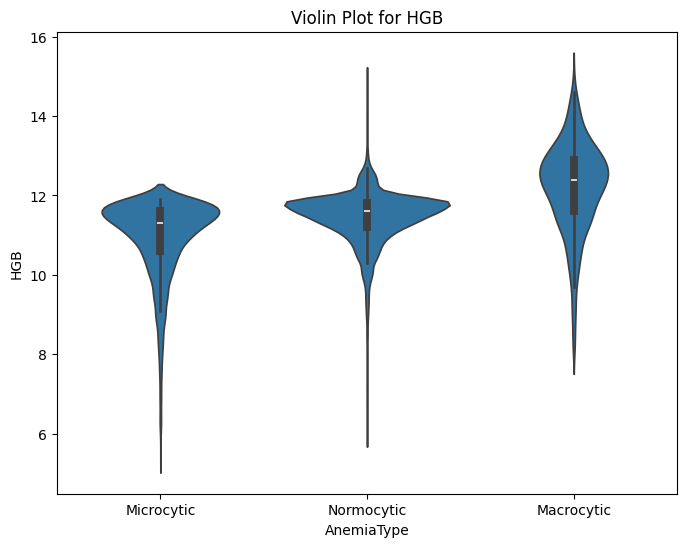

<Figure size 800x600 with 0 Axes>

<Axes: xlabel='AnemiaType', ylabel='HCT'>

Text(0.5, 1.0, 'Violin Plot for HCT')

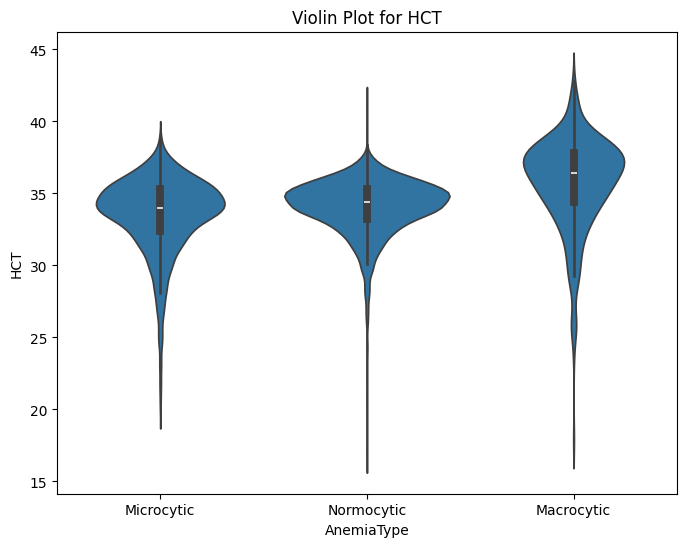

<Figure size 800x600 with 0 Axes>

<Axes: xlabel='AnemiaType', ylabel='MCV'>

Text(0.5, 1.0, 'Violin Plot for MCV')

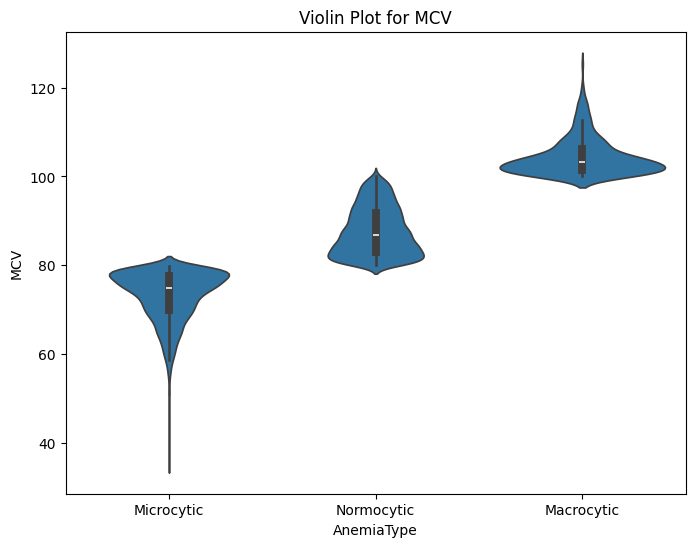

<Figure size 800x600 with 0 Axes>

<Axes: xlabel='AnemiaType', ylabel='MCH'>

Text(0.5, 1.0, 'Violin Plot for MCH')

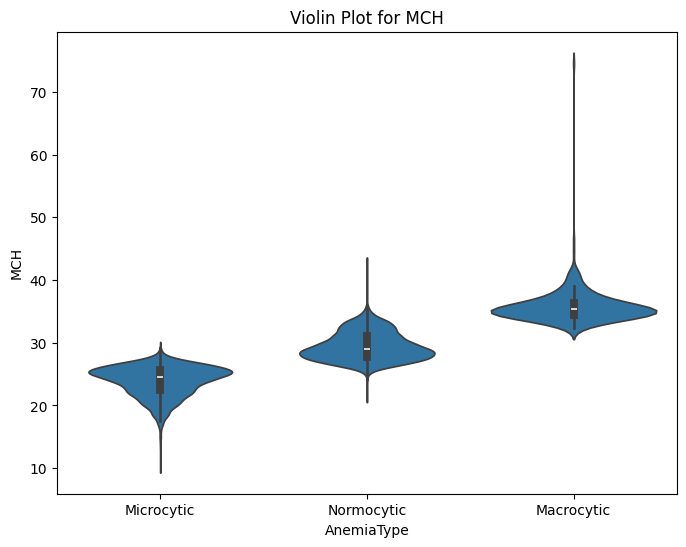

<Figure size 800x600 with 0 Axes>

<Axes: xlabel='AnemiaType', ylabel='MCHC'>

Text(0.5, 1.0, 'Violin Plot for MCHC')

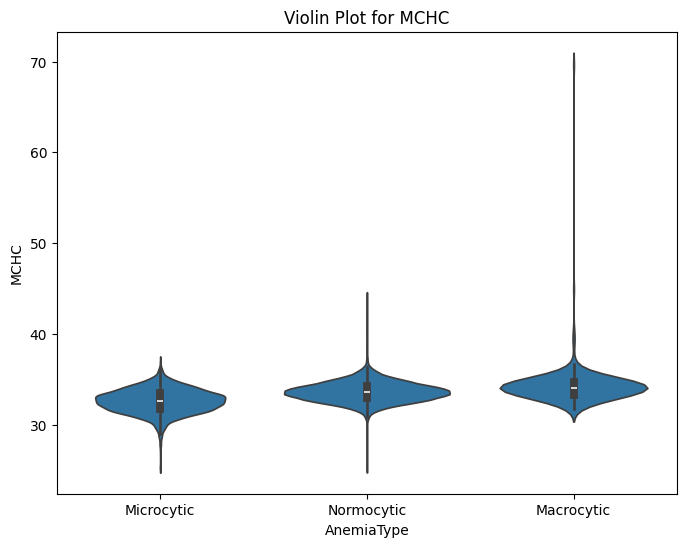

<Figure size 800x600 with 0 Axes>

<Axes: xlabel='AnemiaType', ylabel='RDW'>

Text(0.5, 1.0, 'Violin Plot for RDW')

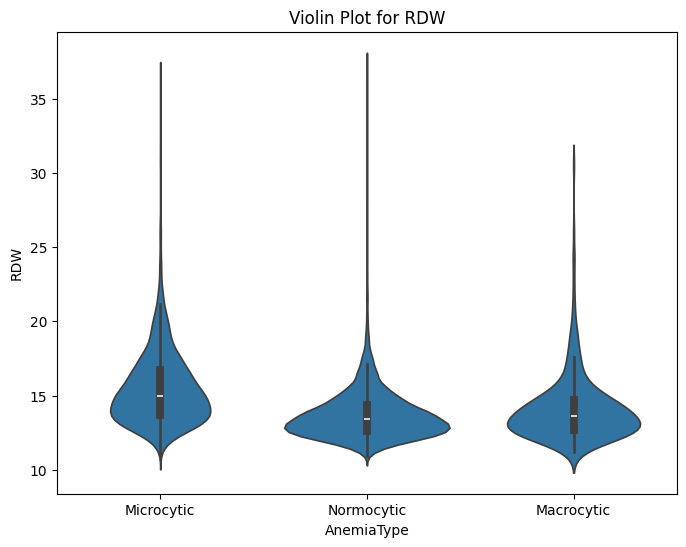

<Figure size 800x600 with 0 Axes>

<Axes: xlabel='AnemiaType', ylabel='PLT'>

Text(0.5, 1.0, 'Violin Plot for PLT')

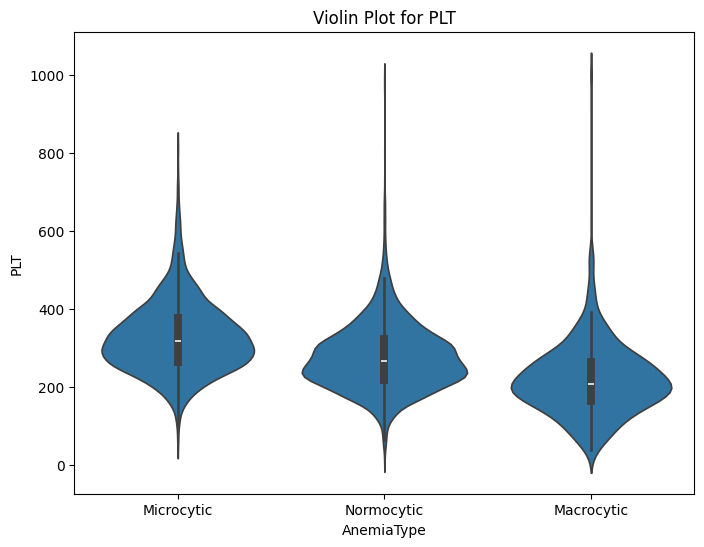

In [23]:
numeric_columns = df_anemia.select_dtypes(include=[np.number]).columns.tolist()

for feature in numeric_columns:
    plt.figure(figsize=(8, 6))
    sns.violinplot(x='AnemiaType', y=feature, data=df_anemia)
    plt.title(f'Violin Plot for {feature}')
    plt.show()


## 4.2.1 Comment:

### Post-analysis observations

1. **HGB and RBC distribution:**
- There is a significant difference in the distribution of *HGB* and *RBC* across anemia types.
- This indicates that the type of anemia affects different levels in the blood cells

2. **HCT and PLT variation:**
- Slight variation in *HCT* and *PLT* was observed across different anemia types.

3. **MCH and MCHC variations:**
- There is a significant difference in *MCH* values ​​although *MCHC* is unchanged

4. **Macrocytic vs. Microcytic and Normocytic Anemia:**
- *Macrocytic anemia* shows significant differences in several features compared to *Microcytic* and *Normocytic* anemia types.
- Although the overall values ​​may appear similar, the *violin plot* revealed distinct details and patterns, highlighting the uniqueness of macrocytic anemia.

In general, deeper insights will be revealed through correlation analysis. [Correlation]

## 4.2.2 Correlation Anemia Types : 

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

def correlation_plots(correlation_matrices, titles, layout='single', fig_size=(7, 7)):
    """
    Plot correlation heatmaps for one or multiple matrices.
    
    Parameters:
    - correlation_matrices (list of DataFrames): List of correlation matrices to plot.
    - titles (list of str): List of titles for each correlation matrix.
    - layout (str): Layout of plots ('single' or 'multi') - 'single' to plot each separately, 'multi' to plot them together.
    - fig_size (tuple): Size of each plot (for 'single') or of entire figure (for 'multi').
    """
    num_plots = len(correlation_matrices)
    
    if layout == 'single':
        # Plot each matrix in a separate figure
        for i in range(num_plots):
            plt.figure(figsize=fig_size)
            sns.heatmap(correlation_matrices[i], annot=True, fmt=".2f", cmap='coolwarm', square=True)
            plt.title(titles[i])
            plt.show()
    elif layout == 'multi':
        # Plot all matrices in a single figure with subplots
        cols = min(num_plots, 3)  # Up to 3 per row for better layout
        rows = (num_plots + cols - 1) // cols
        fig, axes = plt.subplots(rows, cols, figsize=fig_size)
        axes = axes.flatten() if num_plots > 1 else [axes]  # Flatten axes for easy indexing
        
        for i in range(num_plots):
            sns.heatmap(correlation_matrices[i], annot=True, fmt=".2f", cmap='coolwarm', square=True, ax=axes[i])
            axes[i].set_title(titles[i])
        
        # Hide any extra subplots
        for j in range(i + 1, len(axes)):
            axes[j].axis('off')
            
        plt.tight_layout()
        plt.show()



def scatter_plot(fet_1,fet_2 , DataFrame):
    plt.figure(figsize=(10,6))
    sns.regplot(data=DataFrame, x=fet_1, y=fet_2, scatter=True, order=1, label='Linear')
    
    # نضيف منحنى غير خطي (polynomial)
    sns.regplot(data=DataFrame, x=fet_1, y=fet_2, scatter=True, order=2, label='Polynomial')
    
    plt.title(f'{fet_1} vs {fet_2}: Linear vs Non-linear Relationship')
    plt.legend()
    plt.show()

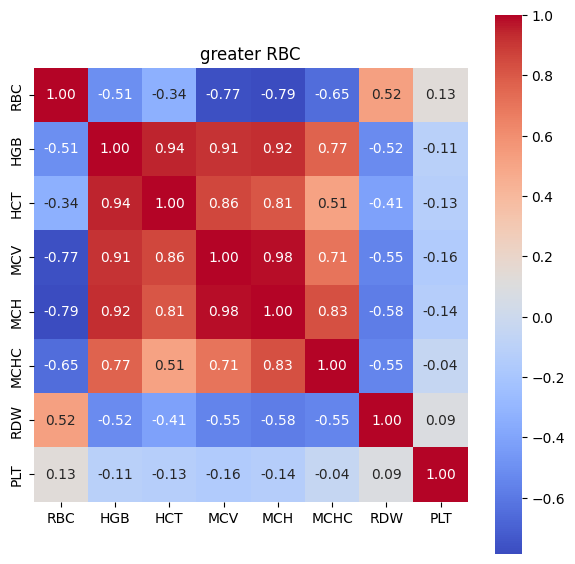

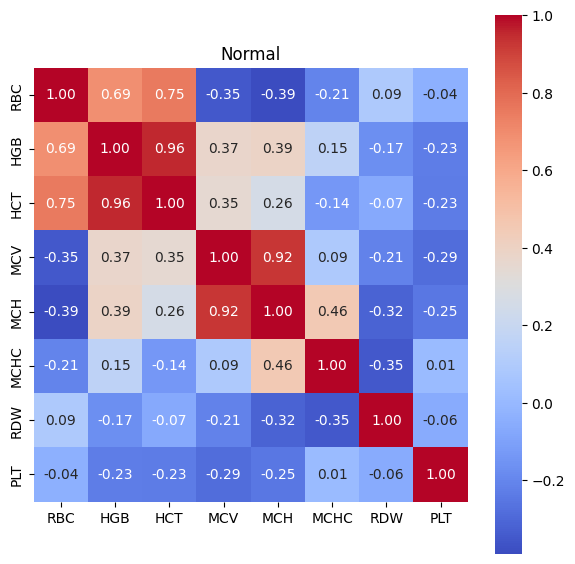

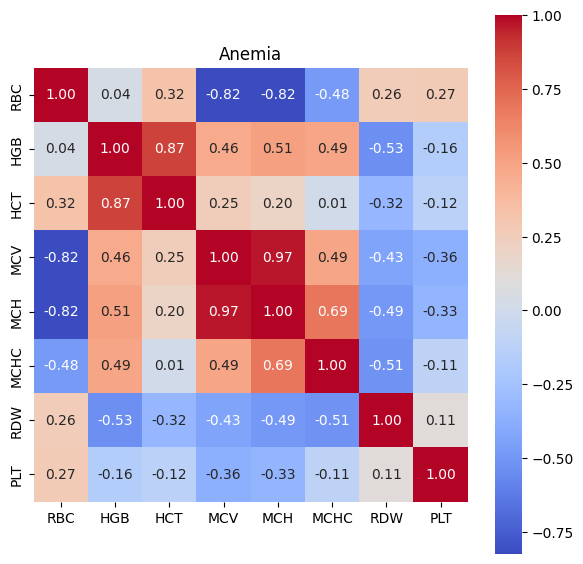

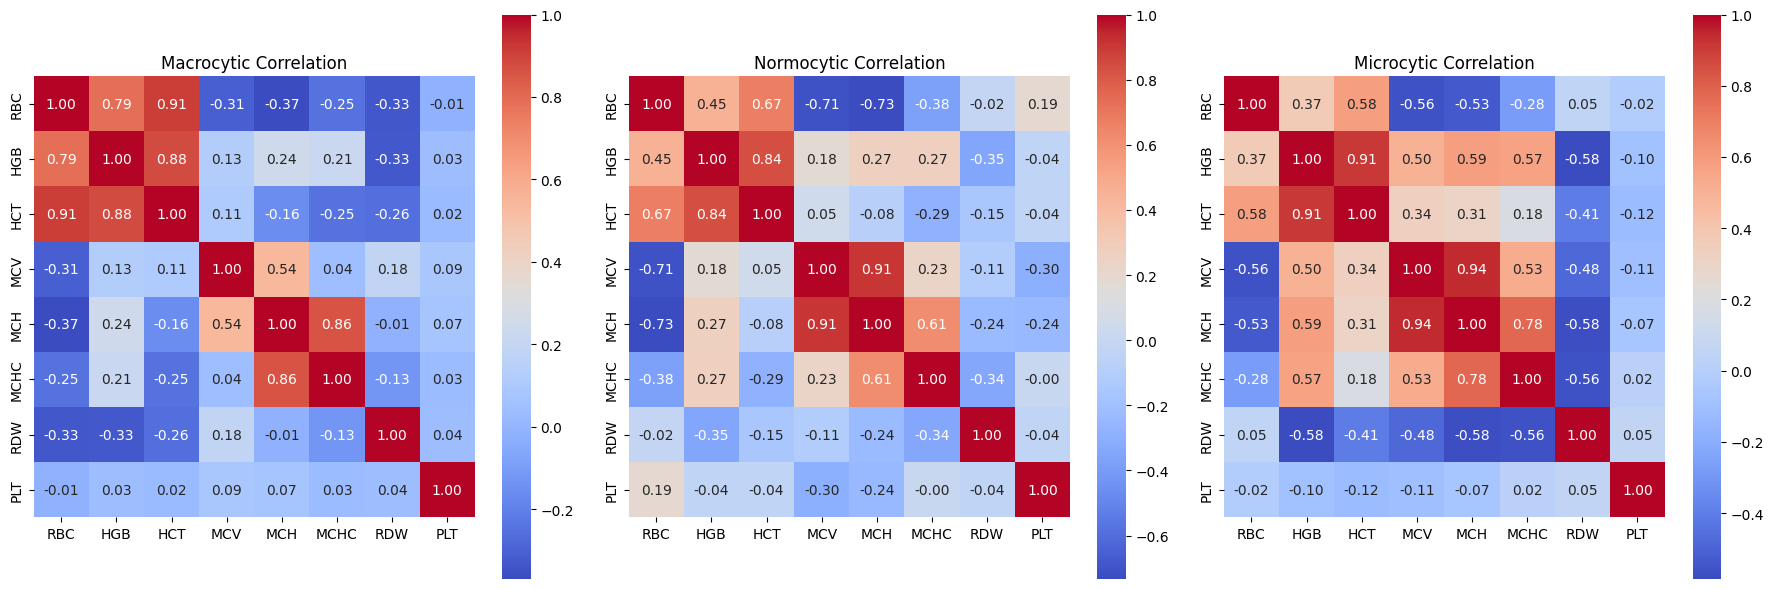

In [27]:
# General correlation matrix
correlation_matrix = df_anemia.drop(['AnemiaType'], axis=1).corr()  # Adding axis=1 to drop column
# Microcytic correlation matrix
correlation_matrix_micro = df_microcytic.drop(['AnemiaType'], axis=1).corr()
# Normocytic correlation matrix
correlation_matrix_normo = df_normocytic.drop(['AnemiaType'], axis=1).corr()
# Macrocytic correlation matrix
correlation_matrix_macro = df_macrocytic.drop(['AnemiaType'], axis=1).corr()
correlation_matrix_greater = df_RBC_GREATER.corr()
correlation_matrix_normal = df_RBC_NORMAL.corr() # Adding axis=1 to drop column
# Display the plots
correlation_plots([correlation_matrix_greater], ['greater RBC'], layout='single', fig_size=(7, 7))
correlation_plots([correlation_matrix_normal], ['Normal'], layout='single', fig_size=(7, 7))
correlation_plots([correlation_matrix], ['Anemia'], layout='single', fig_size=(7, 7))
correlation_plots(
    correlation_matrices=[correlation_matrix_macro, correlation_matrix_normo, correlation_matrix_micro],
    titles=['Macrocytic Correlation', 'Normocytic Correlation', 'Microcytic Correlation'],
    layout='multi',  # لطباعة الرسومات جنبًا إلى جنب في نفس الشكل
    fig_size=(18, 6)  # حجم الشكل الكامل عند استخدام `multi`
)


In [28]:
def create_correlation_comparison(correlation_matrices):
    """
    تحليل الارتباطات بين المتغيرات لأنواع مختلفة من فقر الدم
    
    Parameters:
    correlation_matrices (dict): قواميس تحتوي على مصفوفات الارتباط لكل نوع من فقر الدم
    
    Returns:
    pd.DataFrame: جدول يحتوي على مقارنة الارتباطات القوية بين المتغيرات
    """
    # تعريف حدود الارتباط
    UPPER_THRESHOLD = 0.5
    LOWER_THRESHOLD = -0.4
    
    # إنشاء قائمة لتخزين جميع العلاقات
    all_relations = []
    
    # معالجة كل نوع من فقر الدم
    for anemia_type, corr_matrix in correlation_matrices.items():
        # الحصول على المثلث العلوي من مصفوفة الارتباط لتجنب التكرار
        upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        
        # تحديد الارتباطات القوية
        strong_correlations = upper_triangle[
            (upper_triangle >= UPPER_THRESHOLD) | 
            (upper_triangle <= LOWER_THRESHOLD)
        ]
        
        # جمع العلاقات القوية
        for feature1, row in strong_correlations.items():
            for feature2, corr_value in row.dropna().items():
                relation = f"{feature1}/{feature2}"
                all_relations.append({
                    'Relation': relation,
                    'Anemia_Type': anemia_type,
                    'Correlation': corr_value
                })
    
    # تحويل القائمة إلى DataFrame
    relations_df = pd.DataFrame(all_relations)
    
    # إعادة تشكيل البيانات لتكون في الشكل المطلوب
    comparison_df = relations_df.pivot(
        index='Relation',
        columns='Anemia_Type',
        values='Correlation'
    ).reset_index()
    
    # ملء القيم المفقودة
    comparison_df.fillna('No Strong Correlation', inplace=True)
    
    return comparison_df

# استخدام الدالة
anemia_types = ['Microcytic', 'Normocytic', 'Macrocytic']
correlation_matrices = {
    'Microcytic': correlation_matrix_micro,
    'Normocytic': correlation_matrix_normo,
    'Macrocytic': correlation_matrix_macro
}

comparison_df = create_correlation_comparison(correlation_matrices)

/tmp/ipykernel_68396/443346295.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'No Strong Correlation' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  comparison_df.fillna('No Strong Correlation', inplace=True)


In [29]:
# Sort by Microcytic correlations in descending order
comparison_df_micro = comparison_df.sort_values(by='Microcytic', ascending=False, key=lambda col: pd.to_numeric(col, errors='coerce')).reset_index(drop=True)

# Sort by Normocytic correlations in descending order
comparison_df_normo = comparison_df.sort_values(by='Normocytic', ascending=False, key=lambda col: pd.to_numeric(col, errors='coerce')).reset_index(drop=True)

# Sort by Macrocytic correlations in descending order
comparison_df_macro = comparison_df.sort_values(by='Macrocytic', ascending=False, key=lambda col: pd.to_numeric(col, errors='coerce')).reset_index(drop=True)

# Display the sorted dataframes
print("Sorted by Microcytic Correlations:")
display(comparison_df_micro)

print("\nSorted by Normocytic Correlations:")
display(comparison_df_normo)

print("\nSorted by Macrocytic Correlations:")
display(comparison_df_macro)


Sorted by Microcytic Correlations:


Anemia_Type,Relation,Macrocytic,Microcytic,Normocytic
0,MCH/MCV,0.542587,0.940087,0.907772
1,HCT/HGB,0.880521,0.907517,0.838345
2,MCHC/MCH,0.859841,0.779638,0.614616
3,MCH/HGB,No Strong Correlation,0.585076,No Strong Correlation
4,HCT/RBC,0.911366,0.582969,0.668793
5,MCHC/HGB,No Strong Correlation,0.570064,No Strong Correlation
6,MCHC/MCV,No Strong Correlation,0.526108,No Strong Correlation
7,MCV/HGB,No Strong Correlation,0.501769,No Strong Correlation
8,RDW/HCT,No Strong Correlation,-0.410926,No Strong Correlation
9,RDW/MCV,No Strong Correlation,-0.481598,No Strong Correlation



Sorted by Normocytic Correlations:


Anemia_Type,Relation,Macrocytic,Microcytic,Normocytic
0,MCH/MCV,0.542587,0.940087,0.907772
1,HCT/HGB,0.880521,0.907517,0.838345
2,HCT/RBC,0.911366,0.582969,0.668793
3,MCHC/MCH,0.859841,0.779638,0.614616
4,MCV/RBC,No Strong Correlation,-0.562345,-0.709165
5,MCH/RBC,No Strong Correlation,-0.531357,-0.733247
6,HGB/RBC,0.79099,No Strong Correlation,No Strong Correlation
7,MCH/HGB,No Strong Correlation,0.585076,No Strong Correlation
8,MCHC/HGB,No Strong Correlation,0.570064,No Strong Correlation
9,MCHC/MCV,No Strong Correlation,0.526108,No Strong Correlation



Sorted by Macrocytic Correlations:


Anemia_Type,Relation,Macrocytic,Microcytic,Normocytic
0,HCT/RBC,0.911366,0.582969,0.668793
1,HCT/HGB,0.880521,0.907517,0.838345
2,MCHC/MCH,0.859841,0.779638,0.614616
3,HGB/RBC,0.79099,No Strong Correlation,No Strong Correlation
4,MCH/MCV,0.542587,0.940087,0.907772
5,MCH/HGB,No Strong Correlation,0.585076,No Strong Correlation
6,MCH/RBC,No Strong Correlation,-0.531357,-0.733247
7,MCHC/HGB,No Strong Correlation,0.570064,No Strong Correlation
8,MCHC/MCV,No Strong Correlation,0.526108,No Strong Correlation
9,MCV/HGB,No Strong Correlation,0.501769,No Strong Correlation


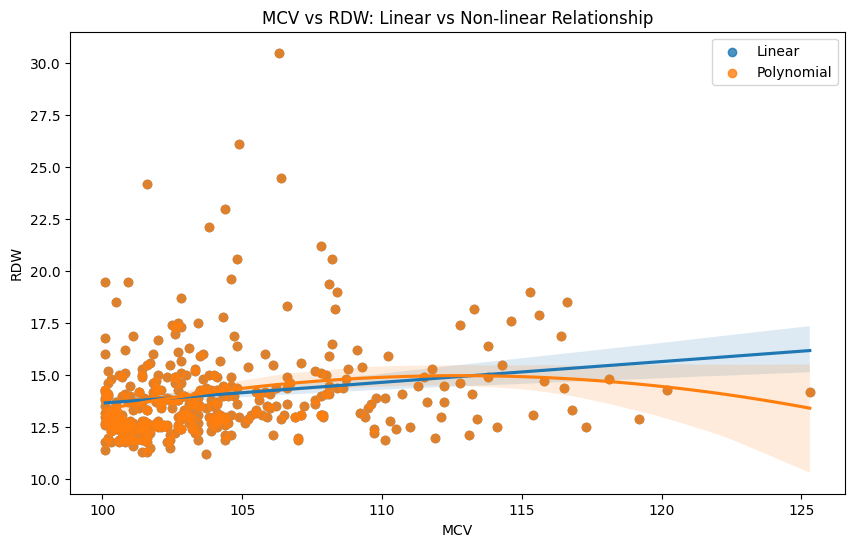

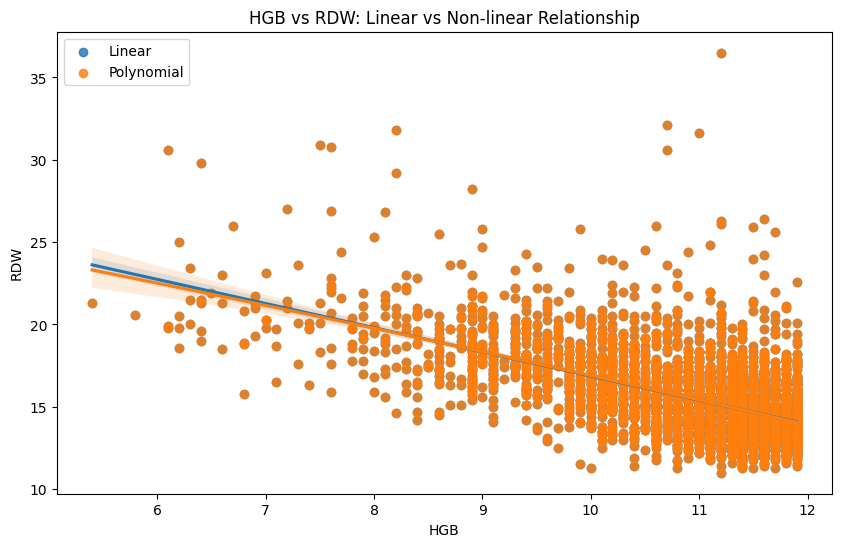

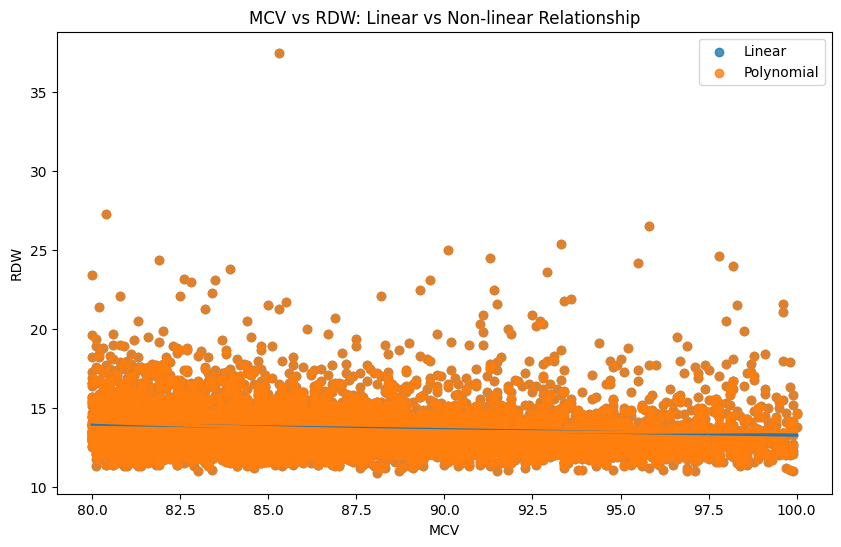

In [30]:

# scatter_plot('HCT','MCV' , df_macrocytic.sample(frac=1))
# scatter_plot('HCT','RBC' , df_macrocytic.sample(frac=1))
# scatter_plot('HCT','HGB' , df_macrocytic.sample(frac=1))
# scatter_plot('MCV','RBC' , df_anemia.sample(frac=0.2))
# scatter_plot('MCV','RBC' , df_RBC_NORMAL.sample(frac=0.2))
# scatter_plot('MCV','RBC' , df.sample(frac=0.2))
# scatter_plot('MCV','RBC' , df_macrocytic.sample(frac=1))
# scatter_plot('MCV','RBC' , df_normocytic.sample(frac=1))
# scatter_plot('MCV','RBC' , df_microcytic.sample(frac=1))
#scatter_plot('MCV','MCH' , df)
# scatter_plot('HGB','MCH' , df_macrocytic.sample(frac=1))
# scatter_plot('HGB','MCH' , df_microcytic.sample(frac=1))
# scatter_plot('HGB','MCH' , df_normocytic.sample(frac=1))

# scatter_plot('HGB','MCHC' , df_macrocytic.sample(frac=1))
# scatter_plot('HGB','MCHC' , df_microcytic.sample(frac=1))
# scatter_plot('HGB','MCHC' , df_normocytic.sample(frac=1))

scatter_plot('MCV','RDW' , df_macrocytic.sample(frac=1))
scatter_plot('HGB','RDW' , df_microcytic.sample(frac=1))
scatter_plot('MCV','RDW' , df_normocytic.sample(frac=1))

In [31]:
def diagnose_microcytic_anemia(row):
    """
    تشخيص فقر الدم الميكروسيتي (صغير الكريات) بناءً على المؤشرات المختلفة
    المراجع العلمية:
    - Nathan and Oski's Hematology of Infancy and Childhood
    - Williams Hematology, 10th Edition
    """
    diagnosis = []
    
    # Iron Deficiency Anemia (IDA) Pattern
    if (row['MCV'] < 80 and row['MCH'] < 27 and row['RDW'] > 14.5):
        if row['RDW'] > 17.5:
            diagnosis.append("Iron Deficiency Anemia - Late Stage")
        else:
            diagnosis.append("Iron Deficiency Anemia - Early Stage")
            
    # Thalassemia Pattern
    if (row['MCV'] < 80 and row['MCH'] < 27 and row['RDW'] < 14.5 and 
        row['RBC'] > 4.0):  # RBC often elevated or normal in thalassemia
        if row['RBC'] > 5.5:
            diagnosis.append("Beta Thalassemia Minor - Likely")
        else:
            diagnosis.append("Thalassemia Trait - Possible")
            
    # Mentzer Index (MI = MCV/RBC)
    mentzer_index = row['MCV'] / row['RBC']
    if mentzer_index < 13:
        diagnosis.append("Suggests Thalassemia")
    elif mentzer_index > 13:
        diagnosis.append("Suggests Iron Deficiency")
        
    return ' | '.join(diagnosis) if diagnosis else "Requires Further Investigation"

def diagnose_macrocytic_anemia(row):
    """
    تشخيص فقر الدم كبير الكريات
    """
    diagnosis = []
    
    # Classic B12/Folate Deficiency Pattern
    if (row['MCV'] > 100 and row['MCH'] > 34):
        if row['RDW'] > 16:
            diagnosis.append("Vitamin B12/Folate Deficiency - Active")
        else:
            diagnosis.append("Megaloblastic Anemia - Early Stage")
    
    # Evaluate RDW for mixed picture
    if row['RDW'] > 18:
        diagnosis.append("Severe Nutritional Deficiency")
        
    return ' | '.join(diagnosis) if diagnosis else "Requires Further Investigation"

def diagnose_normocytic_anemia(row):
    """
    تشخيص فقر الدم سوي الكريات
    """
    diagnosis = []
    
    # Chronic Disease Pattern
    if (row['MCV'] >= 80 and row['MCV'] <= 100 and row['RDW'] < 15):
        diagnosis.append("Anemia of Chronic Disease - Possible")
        
    # Early Iron Deficiency or Mixed Picture
    if (row['MCV'] >= 80 and row['MCV'] <= 100 and row['RDW'] > 15):
        diagnosis.append("Early Iron Deficiency or Mixed Deficiency")
        
    # Acute Blood Loss Pattern
    if (row['RDW'] < 15 and row['MCHC'] > 32):
        diagnosis.append("Recent Acute Blood Loss - Possible")
        
    return ' | '.join(diagnosis) if diagnosis else "Requires Further Investigation"

def analyze_anemia_severity(row):
    """
    تحديد شدة فقر الدم بناءً على مستوى الهيموجلوبين
    """
    if row['HGB'] >= 10:
        return "Mild"
    elif 7 <= row['HGB'] < 10:
        return "Moderate"
    elif 4 <= row['HGB'] < 7:
        return "Severe"
    else:
        return "Critical"

def comprehensive_anemia_analysis(df_anemia):
    """
    تحليل شامل لفقر الدم
    """
    # Create copy to avoid modifying original data
    df_analysis = df_anemia.copy()
    
    # Add severity analysis
    df_analysis['Severity'] = df_analysis.apply(analyze_anemia_severity, axis=1)
    
    # Add specific diagnoses based on anemia type
    conditions = {
        'Microcytic': diagnose_microcytic_anemia,
        'Macrocytic': diagnose_macrocytic_anemia,
        'Normocytic': diagnose_normocytic_anemia
    }
    
    df_analysis['Detailed_Diagnosis'] = df_analysis.apply(
        lambda row: conditions[row['AnemiaType']](row) 
        if row['AnemiaType'] in conditions else "Unknown Type",
        axis=1
    )
    
    return df_analysis

# Function to generate summary statistics for each anemia type
def generate_anemia_stats(df_analysis):
    """
    توليد إحصائيات تفصيلية لكل نوع من أنواع فقر الدم
    """
    stats = {}
    for anemia_type in df_analysis['AnemiaType'].unique():
        subset = df_analysis[df_analysis['AnemiaType'] == anemia_type]
        stats[anemia_type] = {
            'count': len(subset),
            'severity_distribution': subset['Severity'].value_counts(),
            'mean_values': {
                'HGB': subset['HGB'].mean(),
                'MCV': subset['MCV'].mean(),
                'MCH': subset['MCH'].mean(),
                'RDW': subset['RDW'].mean(),
                'RBC': subset['RBC'].mean()
            },
            'diagnosis_distribution': subset['Detailed_Diagnosis'].value_counts()
        }
    return stats

# Example usage
def main_analysis(df_microcytic, df_normocytic, df_macrocytic):
    """
    التحليل الرئيسي لجميع أنواع فقر الدم
    """
    # Combine all anemia DataFrames
    df_all_anemia = pd.concat([
        df_microcytic.assign(AnemiaType='Microcytic'),
        df_normocytic.assign(AnemiaType='Normocytic'),
        df_macrocytic.assign(AnemiaType='Macrocytic')
    ])
    
    # Perform comprehensive analysis
    results = comprehensive_anemia_analysis(df_all_anemia)
    
    # Generate statistics
    stats = generate_anemia_stats(results)
    
    return results, stats

In [32]:
# تحليل البيانات
results, stats = main_analysis(df_microcytic, df_normocytic, df_macrocytic)

# عرض النتائج لمريض معين
try:
    print(results.iloc[0][['AnemiaType', 'Severity', 'Detailed_Diagnosis']])
except KeyError:
    print("Error: One or more columns are missing in results.")
except IndexError:
    print("Error: No rows available in results.")

# عرض إحصائيات لنوع معين من فقر الدم
if 'Microcytic' in stats:
    print(stats['Microcytic'])
else:
    print("Error: 'Microcytic' type is not available in stats.")


AnemiaType                                                   Microcytic
Severity                                                       Moderate
Detailed_Diagnosis    Iron Deficiency Anemia - Early Stage | Suggest...
Name: 18170, dtype: object
{'count': 3797, 'severity_distribution': Severity
Mild        3274
Moderate     493
Severe        30
Name: count, dtype: int64, 'mean_values': {'HGB': np.float64(10.932262312351858), 'MCV': np.float64(73.22778509349487), 'MCH': np.float64(23.908717408480378), 'RDW': np.float64(15.506215433236765), 'RBC': np.float64(4.594414011061364)}, 'diagnosis_distribution': Detailed_Diagnosis
Iron Deficiency Anemia - Early Stage | Suggests Iron Deficiency    1328
Thalassemia Trait - Possible | Suggests Iron Deficiency            1266
Iron Deficiency Anemia - Late Stage | Suggests Iron Deficiency      512
Suggests Iron Deficiency                                            291
Iron Deficiency Anemia - Early Stage | Suggests Thalassemia         204
Iron Deficienc

In [33]:
df_RBC_NORMAL

,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT
18168,4.73,14.1,41.8,88.5,29.7,33.6,13.7,214.0
18169,4.52,13.7,39.3,86.9,30.3,34.8,11.7,270.0
18171,5.13,14.5,43.6,84.9,28.3,33.3,13.1,209.0
18172,4.22,13.1,38.7,91.7,30.9,33.7,12.8,453.0
18173,4.60,13.4,40.2,87.4,29.1,33.3,14.3,244.0
...,...,...,...,...,...,...,...,...
8718,4.67,14.4,41.0,87.8,30.8,35.0,13.1,240.0
8719,5.10,14.1,42.5,83.2,27.7,33.3,14.3,284.0
8721,4.34,13.6,39.4,90.7,31.2,34.4,13.8,353.0
8725,4.94,14.7,43.9,88.7,29.6,33.4,13.4,230.0


In [34]:
import pandas as pd

# افترض أن df_RBC_NORMAL هو اسم DataFrame الخاص بك
# هذا هو المثال، تأكد من أن الأعمدة تحمل الأسماء الصحيحة حسب DataFrame لديك

# تعريف القيم الطبيعية لكل مؤشر
normal_ranges = {
    'MCV': (80, 100),  # قم بتحديث القيم حسب النطاقات الطبيعية
    'HCT': (38, 50),   # قم بتحديث القيم حسب النطاقات الطبيعية
    'MCHC': (32, 36),  # قم بتحديث القيم حسب النطاقات الطبيعية
    'RDW': (11.5, 14.5)  # قم بتحديث القيم حسب النطاقات الطبيعية
}

# فحص القيم غير الطبيعية
results = {}
for index, (col, (low, high)) in enumerate(normal_ranges.items()):
    abnormal_count = df_RBC_NORMAL[(df_RBC_NORMAL[col] < low) | (df_RBC_NORMAL[col] > high)].shape[0]
    total_count = df_RBC_NORMAL.shape[0]
    results[col] = {
        'Abnormal Count': abnormal_count,
        'Total Count': total_count,
        'Percentage Abnormal': (abnormal_count / total_count) * 100 if total_count > 0 else 0
    }

# تحويل النتائج إلى DataFrame
abnormality_report = pd.DataFrame(results).T
print(abnormality_report)


      Abnormal Count  Total Count  Percentage Abnormal
MCV           6945.0      84625.0             8.206795
HCT          17045.0      84625.0            20.141802
MCHC          1982.0      84625.0             2.342097
RDW           7180.0      84625.0             8.484490


In [35]:


# افترض أن df_RBC_NORMAL هو DataFrame الذي يحتوي على بيانات القيم الطبيعية

# تحديد النطاقات الطبيعية
normal_hgb_range = (12,17.5)  # للذكور
normal_rbc_range = (3.8, 5)     # للذكور
normal_hct_range = (34, 44)   # للذكور

# تصفية البيانات
filtered_data = df_RBC_NORMAL[
    (df_RBC_NORMAL['HGB'].between(*normal_hgb_range)) &
    (df_RBC_NORMAL['RBC'].between(*normal_rbc_range)) &
    (df_RBC_NORMAL['HCT'].between(*normal_hct_range))
]

# احصاء القيم الخاصة بـ MCV في البيانات المصفاة
mcv_abnormal_count = filtered_data[filtered_data['MCV'] < 80].shape[0] + filtered_data[filtered_data['MCV'] > 100].shape[0]
mcv_total_count = filtered_data.shape[0]

# حساب النسبة
if mcv_total_count > 0:
    mcv_percentage_abnormal = (mcv_abnormal_count / mcv_total_count) * 100
else:
    mcv_percentage_abnormal = 0

print(f"Total Count with Normal HGB, RBC, HCT: {mcv_total_count}")
print(f"Abnormal MCV Count: {mcv_abnormal_count}")
print(f"Percentage of Abnormal MCV: {mcv_percentage_abnormal:.2f}%")


Total Count with Normal HGB, RBC, HCT: 57034
Abnormal MCV Count: 3878
Percentage of Abnormal MCV: 6.80%


In [36]:
df_anemia

,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT,AnemiaType
18170,4.77,9.3,29.4,61.5,19.4,31.6,15.3,471.0,Microcytic
18182,3.57,10.9,33.3,93.0,30.4,32.7,14.1,219.0,Normocytic
18184,3.99,11.1,33.8,84.8,27.9,32.9,13.3,435.0,Normocytic
18195,4.48,11.7,35.2,78.4,26.1,33.3,11.8,347.0,Microcytic
18204,4.32,11.4,35.0,81.0,26.6,32.8,13.9,347.0,Normocytic
...,...,...,...,...,...,...,...,...,...
8661,4.37,11.0,34.7,79.3,25.2,31.8,14.3,347.0,Microcytic
8667,3.34,10.8,32.3,97.0,32.4,33.4,12.8,220.0,Normocytic
8684,3.84,11.9,34.6,90.0,30.9,34.3,13.0,307.0,Normocytic
8716,4.35,9.0,29.0,66.6,20.9,31.3,19.8,231.0,Microcytic


In [37]:

# استخرج الصفوف التي تحتوي على HGB و HCT طبيعيين و RBC منخفض
normal_hgb_hct = df_anemia[
    (df_anemia['HGB'] >= normal_hgb_range[0]) & (df_anemia['HGB'] <= normal_hgb_range[1]) &  # تأكد من أن الهيموجلوبين طبيعي
    (df_anemia['HCT'] >= normal_hct_range[0]) & (df_anemia['HCT'] <= normal_hct_range[1]) &   # تأكد من أن HCT طبيعي
    (df_anemia['RBC'] < normal_rbc_range[0])  # تأكد من أن RBC منخفض
]

# عرض النتائج
normal_hgb_hct


,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT,AnemiaType
18289,3.52,12.1,34.7,98.5,34.1,34.7,11.5,274.0,Normocytic
18516,3.63,12.5,36.0,99.1,34.5,34.8,12.0,312.0,Normocytic
18745,3.59,12.1,34.6,96.2,33.7,35.0,12.1,192.0,Normocytic
18847,3.76,12.4,36.1,95.7,32.7,34.2,12.1,181.0,Normocytic
18867,3.70,12.2,35.4,95.7,32.9,34.4,12.3,217.0,Normocytic
...,...,...,...,...,...,...,...,...,...
8393,3.73,12.4,34.8,93.2,33.0,35.5,14.4,171.0,Normocytic
8443,3.78,12.2,35.7,94.6,32.1,34.0,14.6,190.0,Normocytic
8567,3.79,12.4,37.1,98.0,32.6,33.3,14.7,195.0,Normocytic
8658,3.79,12.4,37.2,98.1,32.8,33.4,15.9,218.0,Normocytic


In [38]:
# استخرج الصفوف التي تحتوي على HGB وHCT وRBC طبيعيين
normal_values = df_anemia[
    (df_anemia['HGB'] >= normal_hgb_range[0]) & (df_anemia['HGB'] <= normal_hgb_range[1]) &  # تأكد من أن الهيموجلوبين طبيعي
    (df_anemia['HCT'] >= normal_hct_range[0]) & (df_anemia['HCT'] <= normal_hct_range[1]) &   # تأكد من أن HCT طبيعي
    (df_anemia['RBC'] >= normal_rbc_range[0]) & (df_anemia['RBC'] <= normal_rbc_range[1])   # تأكد من أن RBC طبيعي
]

# استخرج MCV أقل من 80
mcv_low = normal_values[normal_values['MCV'] < 80]

# استخرج MCV أكبر من أو يساوي 80
mcv_high = normal_values[normal_values['MCV'] >100]

# عرض النتائج
print("Rows with Normal HGB, HCT, RBC and MCV < 80:")
print(mcv_low)

print("\nRows with Normal HGB, HCT, RBC and MCV >= 80:")
print(mcv_high)


Rows with Normal HGB, HCT, RBC and MCV < 80:
Empty DataFrame
Columns: [RBC, HGB, HCT, MCV, MCH, MCHC, RDW, PLT, AnemiaType]
Index: []

Rows with Normal HGB, HCT, RBC and MCV >= 80:
Empty DataFrame
Columns: [RBC, HGB, HCT, MCV, MCH, MCHC, RDW, PLT, AnemiaType]
Index: []


In [39]:
# استخرج الصفوف التي تحتوي على HCT مرتفع و HGB طبيعي و RBC منخفض
high_hct_normal_hgb_low_rbc = df_anemia[
    (df_anemia['HCT'] > normal_hct_range[1]) &               # تأكد من أن HCT مرتفع
    (df_anemia['HGB'] >= normal_hgb_range[0]) & (df_anemia['HGB'] <= normal_hgb_range[1]) &  # تأكد من أن HGB طبيعي
    (df_anemia['RBC'] < normal_rbc_range[0])                  # تأكد من أن RBC منخفض
]

# عرض النتائج
high_hct_normal_hgb_low_rbc


,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT,AnemiaType


In [40]:
# استخرج الصفوف التي تحتوي على HCT منخفض و HGB طبيعي و RBC منخفض
low_hct_normal_hgb_low_rbc = df_anemia[
    (df_anemia['HCT'] < normal_hct_range[0]) &               # تأكد من أن HCT منخفض
    (df_anemia['HGB'] >= normal_hgb_range[0]) & (df_anemia['HGB'] <= normal_hgb_range[1]) &  # تأكد من أن HGB طبيعي
    (df_anemia['RBC'] < normal_rbc_range[0])                  # تأكد من أن RBC منخفض
]

low_hct_normal_hgb_low_rbc.describe()
# عرض عدد تكرارات كل نوع من الأنيميا
anemia_type_counts = low_hct_normal_hgb_low_rbc['AnemiaType'].value_counts()

anemia_type_counts

,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT
count,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000
mean,3.487727,12.297727,32.861364,94.629545,35.822727,37.754545,12.931818,270.795455
std,0.347609,0.458759,2.537277,5.168085,6.735358,5.449406,1.146840,77.260231
min,1.670000,12.000000,17.900000,84.600000,31.600000,35.300000,11.400000,142.000000
25%,3.452500,12.000000,32.900000,92.250000,32.875000,35.700000,12.275000,219.000000
50%,3.555000,12.100000,33.600000,93.700000,34.050000,36.050000,12.800000,253.500000
75%,3.642500,12.325000,33.800000,97.100000,35.575000,37.425000,13.350000,318.750000
max,3.790000,14.000000,33.900000,113.300000,74.500000,69.600000,18.200000,488.000000


AnemiaType
Normocytic    40
Macrocytic     4
Name: count, dtype: int64

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='HCT', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of HCT by Anemia Type')

Text(0.5, 0, 'HCT')

Text(0, 0.5, 'Frequency')

/tmp/ipykernel_68396/2160338077.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Anemia Type')


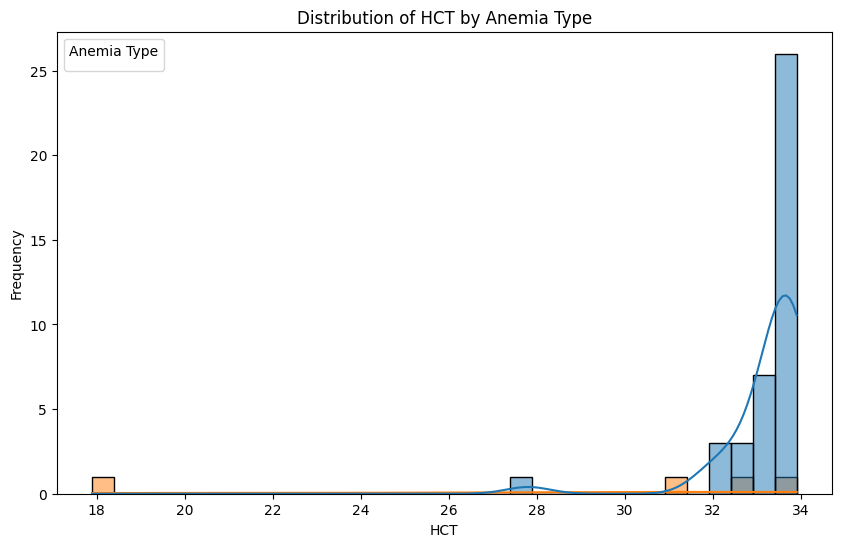

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='RBC', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of RBC by Anemia Type')

Text(0.5, 0, 'RBC')

Text(0, 0.5, 'Frequency')

/tmp/ipykernel_68396/2160338077.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Anemia Type')


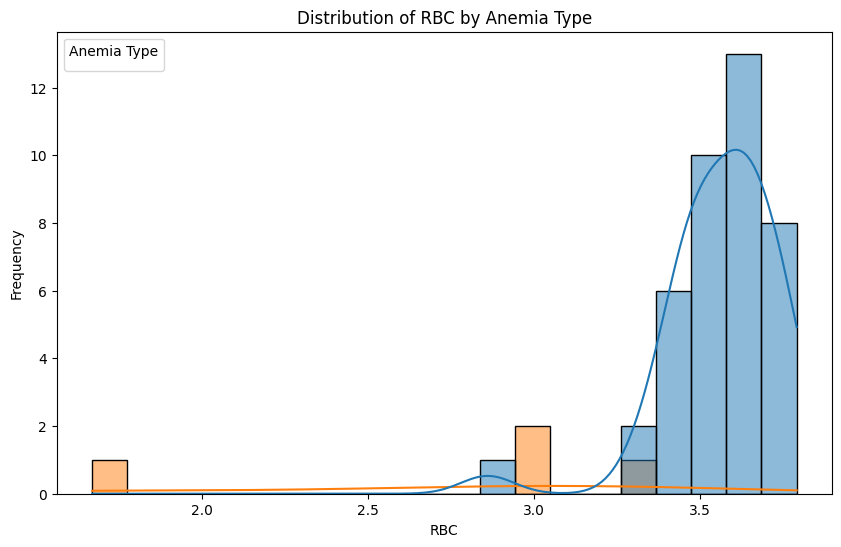

In [ ]:

# اختيار البيانات التي تحتوي على HCT منخفض و HGB طبيعي و RBC منخفض
low_hct_normal_hgb_low_rbc = df_anemia[
    (df_anemia['HCT'] < normal_hct_range[0]) &                # تأكد من أن HCT منخفض
    (df_anemia['HGB'] >= normal_hgb_range[0]) & (df_anemia['HGB'] <= normal_hgb_range[1]) &  # تأكد من أن HGB طبيعي
    (df_anemia['RBC'] < normal_rbc_range[0])                   # تأكد من أن RBC منخفض
]

# توزيع HCT لكل نوع من الأنيميا
plt.figure(figsize=(10, 6))
sns.histplot(data=low_hct_normal_hgb_low_rbc, x='HCT', hue='AnemiaType', kde=True)
plt.title("Distribution of HCT by Anemia Type")
plt.xlabel("HCT")
plt.ylabel("Frequency")
plt.legend(title='Anemia Type')
plt.show()

# توزيع RBC لكل نوع من الأنيميا
plt.figure(figsize=(10, 6))
sns.histplot(data=low_hct_normal_hgb_low_rbc, x='RBC', hue='AnemiaType', kde=True)
plt.title("Distribution of RBC by Anemia Type")
plt.xlabel("RBC")
plt.ylabel("Frequency")
plt.legend(title='Anemia Type')
plt.show()

# التوزيع المشترك بين HCT و RBC لكل نوع من الأنيميا
sns.jointplot(data=low_hct_normal_hgb_low_rbc, x='HCT', y='RBC', hue='AnemiaType', kind="kde", height=8)
plt.suptitle("Joint Distribution of HCT and RBC by Anemia Type", y=1.05)
plt.xlabel("HCT")
plt.ylabel("RBC")
plt.show()


In [ ]:
low_hct_normal_hgb_low_rbc[low_hct_normal_hgb_low_rbc['HCT']<=20]

In [ ]:
df_rbc[df_rbc['HCT']<=20]

In [ ]:
# استخرج الصفوف التي تحتوي على HCT مرتفع و HGB طبيعي و RBC منخفض
normal_hct_normal_hgb_low_rbc = df_anemia[
    (df_anemia['HCT'] >= normal_hct_range[0]) & (df_anemia['HCT'] <= normal_hct_range[1]) &             
    (df_anemia['HGB'] >= normal_hgb_range[0]) & (df_anemia['HGB'] <= normal_hgb_range[1]) & 
    (df_anemia['RBC'] < normal_rbc_range[0])  
]


# عرض النتائج
normal_hct_normal_hgb_low_rbc
anemia_type_counts = normal_hct_normal_hgb_low_rbc['AnemiaType'].value_counts()

anemia_type_counts

In [ ]:
# استخرج الصفوف التي تحتوي على HGB و RBC طبيعي و HCT غير طبيعي

# تحديد النطاقات الطبيعية
normal_hgb_range = (12, 17.5)  # للذكور
normal_rbc_range = (3.8, 5)     # للذكور
normal_hct_range = (34, 44)     # للذكور

abnormal_hct_normal_hgb_normal_rbc = df_anemia[
    ((df_rbc['HCT'] < normal_hct_range[0]) | (df_anemia['HCT'] > normal_hct_range[1])) &  # تأكد من أن HCT غير طبيعي
    (df_rbc['HGB'] >= normal_hgb_range[0]) & (df_anemia['HGB'] <= normal_hgb_range[1]) &  # تأكد من أن HGB طبيعي
    (df_rbc['RBC'] >= normal_rbc_range[0]) & (df_anemia['RBC'] <= normal_rbc_range[1])    # تأكد من أن RBC طبيعي
]

# عرض النتائج
print(abnormal_hct_normal_hgb_normal_rbc)

# حساب عدد الأنواع المختلفة لفقر الدم
anemia_type_counts = abnormal_hct_normal_hgb_normal_rbc['AnemiaType'].value_counts()
print(anemia_type_counts)


In [21]:

# تعريف النطاقات المناسبة لـ MCV
mcv_bins = [0, 80, 100, 130]  # حدود النطاقات لـ MCV
mcv_labels = ['Microcytic (<80)', 'Normocytic (80-100)', 'Macrocytic (>100)']  # تسميات النطاقات

# إضافة عمود جديد للـ MCV
df_rbc['MCV_Category'] = pd.cut(df_rbc['MCV'], bins=mcv_bins, labels=mcv_labels, right=False)

# تحديد النطاقات الطبيعية
normal_hgb_range = (12, 17.5)  # للذكور
normal_rbc_range = (3.8, 5)     # للذكور
normal_hct_range = (34, 44)     # للذكور

# استخراج الاحتمالات الممكنة
results = {}

# HGB Normal, RBC Normal, HCT Normal
results['HGB Normal, RBC Normal, HCT Normal'] = df_rbc[
    (df_rbc['HGB'] >= normal_hgb_range[0]) & (df_rbc['HGB'] <= normal_hgb_range[1]) &
    (df_rbc['RBC'] >= normal_rbc_range[0]) & (df_rbc['RBC'] <= normal_rbc_range[1]) &
    (df_rbc['HCT'] >= normal_hct_range[0]) & (df_rbc['HCT'] <= normal_hct_range[1])
]

# HGB Normal, RBC Normal, HCT Abnormal
results['HGB Normal, RBC Normal, HCT Abnormal'] = df_rbc[
    (df_rbc['HGB'] >= normal_hgb_range[0]) & (df_rbc['HGB'] <= normal_hgb_range[1]) &
    (df_rbc['RBC'] >= normal_rbc_range[0]) & (df_rbc['RBC'] <= normal_rbc_range[1]) &
    (df_rbc['HCT'] < normal_hct_range[0])  # HCT منخفض
]

# HGB Normal, RBC Abnormal, HCT Normal
results['HGB Normal, RBC Abnormal, HCT Normal'] = df_rbc[
    (df_rbc['HGB'] >= normal_hgb_range[0]) & (df_rbc['HGB'] <= normal_hgb_range[1]) &
    (df_rbc['RBC'] < normal_rbc_range[0]) &  # RBC منخفض
    (df_rbc['HCT'] >= normal_hct_range[0]) & (df_rbc['HCT'] <= normal_hct_range[1])
]

# HGB Normal, RBC Abnormal, HCT Abnormal
results['HGB Normal, RBC Abnormal, HCT Abnormal'] = df_rbc[
    (df_rbc['HGB'] >= normal_hgb_range[0]) & (df_rbc['HGB'] <= normal_hgb_range[1]) &
    (df_rbc['RBC'] < normal_rbc_range[0]) &  # RBC منخفض
    (df_rbc['HCT'] < normal_hct_range[0])  # HCT منخفض
]

# HGB Abnormal, RBC Normal, HCT Normal
results['HGB Abnormal, RBC Normal, HCT Normal'] = df_rbc[
    (df_rbc['HGB'] < normal_hgb_range[0]) &  # HGB منخفض
    (df_rbc['RBC'] >= normal_rbc_range[0]) & (df_rbc['RBC'] <= normal_rbc_range[1]) &
    (df_rbc['HCT'] >= normal_hct_range[0]) & (df_rbc['HCT'] <= normal_hct_range[1])
]

# HGB Abnormal, RBC Normal, HCT Abnormal
results['HGB Abnormal, RBC Normal, HCT Abnormal'] = df_rbc[
    (df_rbc['HGB'] < normal_hgb_range[0]) &  # HGB منخفض
    (df_rbc['RBC'] >= normal_rbc_range[0]) & (df_rbc['RBC'] <= normal_rbc_range[1]) &
    (df_rbc['HCT'] < normal_hct_range[0])  # HCT منخفض
]

# HGB Abnormal, RBC Abnormal, HCT Normal
results['HGB Abnormal, RBC Abnormal, HCT Normal'] = df_rbc[
    (df_rbc['HGB'] < normal_hgb_range[0]) &  # HGB منخفض
    (df_rbc['RBC'] < normal_rbc_range[0]) &  # RBC منخفض
    (df_rbc['HCT'] >= normal_hct_range[0]) & (df_rbc['HCT'] <= normal_hct_range[1])
]

# HGB Abnormal, RBC Abnormal, HCT Abnormal
results['HGB Abnormal, RBC Abnormal, HCT Abnormal'] = df_rbc[
    (df_rbc['HGB'] < normal_hgb_range[0]) &  # HGB منخفض
    (df_rbc['RBC'] < normal_rbc_range[0]) &  # RBC منخفض
    (df_rbc['HCT'] < normal_hct_range[0])  # HCT منخفض
]

# حساب عدد كل نوع من الأنيميا في نفس الاحتمال
for case, data in results.items():
    # حساب عدد كل نوع من الأنيميا حسب تصنيف MCV
    mcv_groups = data['MCV_Category'].value_counts()
    print(f"{case}: {len(data)} rows")
    print("MCV Distribution:")
    mcv_groups
    print("\n")


HGB Normal, RBC Normal, HCT Normal: 57034 rows
MCV Distribution:


/tmp/ipykernel_68447/3930730939.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rbc['MCV_Category'] = pd.cut(df_rbc['MCV'], bins=mcv_bins, labels=mcv_labels, right=False)


MCV_Category
Normocytic (80-100)    53147
Microcytic (<80)        3425
Macrocytic (>100)        462
Name: count, dtype: int64



HGB Normal, RBC Normal, HCT Abnormal: 89 rows
MCV Distribution:


MCV_Category
Normocytic (80-100)    64
Microcytic (<80)       24
Macrocytic (>100)       1
Name: count, dtype: int64



HGB Normal, RBC Abnormal, HCT Normal: 764 rows
MCV Distribution:


MCV_Category
Normocytic (80-100)    524
Macrocytic (>100)      240
Microcytic (<80)         0
Name: count, dtype: int64



HGB Normal, RBC Abnormal, HCT Abnormal: 44 rows
MCV Distribution:


MCV_Category
Normocytic (80-100)    40
Macrocytic (>100)       4
Microcytic (<80)        0
Name: count, dtype: int64



HGB Abnormal, RBC Normal, HCT Normal: 4005 rows
MCV Distribution:


MCV_Category
Normocytic (80-100)    2503
Microcytic (<80)       1502
Macrocytic (>100)         0
Name: count, dtype: int64



HGB Abnormal, RBC Normal, HCT Abnormal: 2617 rows
MCV Distribution:


MCV_Category
Microcytic (<80)       1631
Normocytic (80-100)     986
Macrocytic (>100)         0
Name: count, dtype: int64



HGB Abnormal, RBC Abnormal, HCT Normal: 436 rows
MCV Distribution:


MCV_Category
Normocytic (80-100)    386
Macrocytic (>100)       50
Microcytic (<80)         0
Name: count, dtype: int64



HGB Abnormal, RBC Abnormal, HCT Abnormal: 1355 rows
MCV Distribution:


MCV_Category
Normocytic (80-100)    1196
Microcytic (<80)         85
Macrocytic (>100)        74
Name: count, dtype: int64

In [19]:
df_rbc.describe()

,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT
count,95501.000000,95501.000000,95501.000000,95501.000000,95501.000000,95501.000000,95501.000000,95501.000000
mean,4.676628,13.797030,40.726927,87.292241,29.573944,33.863062,13.139576,270.228037
std,0.478841,1.503794,4.293492,6.267451,2.440585,0.970965,1.296097,74.300656
min,1.670000,5.400000,16.300000,35.400000,10.200000,25.100000,6.300000,4.000000
25%,4.360000,12.800000,37.700000,83.700000,28.300000,33.300000,12.300000,219.000000
50%,4.660000,13.700000,40.500000,87.800000,29.800000,33.900000,12.900000,262.000000
75%,4.980000,14.800000,43.700000,91.400000,31.200000,34.500000,13.600000,311.000000
max,9.160000,19.900000,59.900000,125.300000,74.500000,69.600000,37.800000,1021.000000


In [47]:
# تحديد النطاقات الطبيعية لكل من HGB و RBC و HCT
normal_hgb_range = (12, 17.5)  # للذكور
normal_rbc_range = (3.8, 5)     # للذكور
normal_hct_range = (34, 44)     # للذكور

# دالة لتحديد الحالة (Low, Normal, High) بناءً على القيمة والنطاق الطبيعي
def get_status(value, normal_range):
    if value < normal_range[0]:
        return 'Low'
    elif value > normal_range[1]:
        return 'High'
    else:
        return 'Normal'

# إضافة الحالات لكل صف في البيانات بناءً على القيم
df_rbc['HGB_Status'] = df_rbc['HGB'].apply(get_status, normal_range=normal_hgb_range)
df_rbc['RBC_Status'] = df_rbc['RBC'].apply(get_status, normal_range=normal_rbc_range)
df_rbc['HCT_Status'] = df_rbc['HCT'].apply(get_status, normal_range=normal_hct_range)

# استخراج الاحتمالات الممكنة (27 حالة)
results = {}

# توليد الحالات بناءً على كل توليفة من HGB_Status, RBC_Status, و HCT_Status
for hgb_status in ['Low', 'Normal', 'High']:
    for rbc_status in ['Low', 'Normal', 'High']:
        for hct_status in ['Low', 'Normal', 'High']:
            case_name = f"HGB {hgb_status}, RBC {rbc_status}, HCT {hct_status}"
            results[case_name] = df_rbc[
                (df_rbc['HGB_Status'] == hgb_status) &
                (df_rbc['RBC_Status'] == rbc_status) &
                (df_rbc['HCT_Status'] == hct_status)
            ]

# طباعة عدد الحالات لكل احتمال
for case, data in results.items():
    print(f"{case}: {len(data)} rows")
    display(data)
    print(f"{case}: {len(data)} rows")
    data.describe()
    i=input('--------------------------------------Enter  y/n ----------------------------- \n')
    if i == 'y':
        continue
    else :
        break


/tmp/ipykernel_68447/4086625057.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rbc['HGB_Status'] = df_rbc['HGB'].apply(get_status, normal_range=normal_hgb_range)
/tmp/ipykernel_68447/4086625057.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rbc['RBC_Status'] = df_rbc['RBC'].apply(get_status, normal_range=normal_rbc_range)
/tmp/ipykernel_68447/4086625057.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

HGB Low, RBC Low, HCT Low: 1355 rows


,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT,MCV_Category,HGB_Status,RBC_Status,HCT_Status
18182,3.57,10.9,33.3,93.0,30.4,32.7,14.1,219.0,Normocytic (80-100),Low,Low,Low
18300,3.27,11.5,32.0,97.8,35.2,36.0,13.4,187.0,Normocytic (80-100),Low,Low,Low
18326,3.51,11.1,32.6,92.8,31.6,34.2,11.8,229.0,Normocytic (80-100),Low,Low,Low
18450,3.45,10.4,30.9,89.6,30.3,33.8,12.3,195.0,Normocytic (80-100),Low,Low,Low
18493,3.78,10.6,30.9,81.8,28.0,34.2,13.1,280.0,Normocytic (80-100),Low,Low,Low
...,...,...,...,...,...,...,...,...,...,...,...,...
8326,2.76,10.2,28.3,102.6,37.0,36.1,14.9,211.0,Macrocytic (>100),Low,Low,Low
8408,3.44,10.8,32.0,93.1,31.2,33.5,14.5,185.0,Normocytic (80-100),Low,Low,Low
8492,3.55,10.9,32.6,92.0,30.6,33.3,14.6,190.0,Normocytic (80-100),Low,Low,Low
8575,3.08,10.7,32.5,105.5,34.6,32.7,14.2,89.0,Macrocytic (>100),Low,Low,Low


HGB Low, RBC Low, HCT Low: 1355 rows


,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT
count,1355.000000,1355.000000,1355.000000,1355.000000,1355.000000,1355.000000,1355.000000,1355.000000
mean,3.475506,10.557269,31.182731,89.978007,30.455277,33.813801,14.366347,263.373432
std,0.277077,1.031983,2.596472,7.094639,2.917538,1.271809,2.547175,101.105693
min,1.710000,5.800000,16.300000,55.400000,16.400000,27.800000,11.000000,13.000000
25%,3.350000,10.100000,30.200000,86.900000,29.200000,33.150000,12.800000,202.000000
50%,3.560000,10.800000,31.900000,90.400000,30.800000,33.900000,13.700000,248.000000
75%,3.680000,11.300000,33.100000,93.500000,32.000000,34.650000,15.000000,310.000000
max,3.790000,11.900000,33.900000,120.200000,41.800000,40.900000,37.500000,1000.000000


--------------------------------------Enter  y/n ----------------------------- 
 y


HGB Low, RBC Low, HCT Normal: 436 rows


,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT,MCV_Category,HGB_Status,RBC_Status,HCT_Status
18293,3.67,11.6,34.4,93.9,31.6,33.7,11.9,177.0,Normocytic (80-100),Low,Low,Normal
19087,3.63,11.7,34.3,94.6,32.2,34.0,11.7,208.0,Normocytic (80-100),Low,Low,Normal
19227,3.41,11.9,34.3,100.6,34.9,34.7,15.0,286.0,Macrocytic (>100),Low,Low,Normal
19303,3.68,11.4,34.2,92.9,30.8,33.1,15.4,274.0,Normocytic (80-100),Low,Low,Normal
19434,3.66,11.9,34.9,95.4,32.3,33.9,12.2,165.0,Normocytic (80-100),Low,Low,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...
7865,3.75,11.7,35.0,93.4,31.3,33.5,12.5,413.0,Normocytic (80-100),Low,Low,Normal
8086,3.74,11.2,34.4,92.0,29.8,32.4,16.8,305.0,Normocytic (80-100),Low,Low,Normal
8116,3.68,11.7,35.7,97.2,31.9,32.8,14.4,119.0,Normocytic (80-100),Low,Low,Normal
8142,3.56,11.5,34.2,96.2,32.4,33.6,14.5,163.0,Normocytic (80-100),Low,Low,Normal


HGB Low, RBC Low, HCT Normal: 436 rows


,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT
count,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000
mean,3.646032,11.609404,34.736239,95.393119,31.865367,33.412156,13.680963,241.635321
std,0.134002,0.243402,0.606113,3.829858,1.348824,0.733823,1.710691,88.500523
min,3.000000,10.600000,34.000000,89.400000,29.000000,31.100000,11.200000,47.000000
25%,3.590000,11.400000,34.200000,92.800000,31.000000,32.900000,12.500000,180.000000
50%,3.680000,11.600000,34.600000,94.750000,31.650000,33.400000,13.300000,226.000000
75%,3.740000,11.800000,35.100000,97.100000,32.425000,34.000000,14.300000,291.250000
max,3.790000,11.900000,37.000000,115.600000,38.200000,35.100000,24.200000,1000.000000


--------------------------------------Enter  y/n ----------------------------- 
 y


HGB Low, RBC Low, HCT High: 0 rows


,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT,MCV_Category,HGB_Status,RBC_Status,HCT_Status


HGB Low, RBC Low, HCT High: 0 rows


,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


--------------------------------------Enter  y/n ----------------------------- 
 y


HGB Low, RBC Normal, HCT Low: 2617 rows


,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT,MCV_Category,HGB_Status,RBC_Status,HCT_Status
18170,4.77,9.3,29.4,61.5,19.4,31.6,15.3,471.0,Microcytic (<80),Low,Normal,Low
18184,3.99,11.1,33.8,84.8,27.9,32.9,13.3,435.0,Normocytic (80-100),Low,Normal,Low
18249,4.11,11.4,33.4,81.3,27.7,34.1,12.5,400.0,Normocytic (80-100),Low,Normal,Low
18260,3.95,11.1,32.3,81.6,27.9,34.2,13.6,300.0,Normocytic (80-100),Low,Normal,Low
18303,4.41,11.1,33.1,74.9,25.0,33.3,14.0,334.0,Microcytic (<80),Low,Normal,Low
...,...,...,...,...,...,...,...,...,...,...,...,...
8531,4.29,11.5,33.3,77.7,26.7,34.5,14.5,341.0,Microcytic (<80),Low,Normal,Low
8549,4.28,8.2,28.5,66.5,19.0,28.6,22.3,203.0,Microcytic (<80),Low,Normal,Low
8600,3.88,11.5,33.7,86.8,29.6,34.0,13.0,338.0,Normocytic (80-100),Low,Normal,Low
8651,4.06,11.0,32.0,78.8,27.2,34.5,14.2,393.0,Microcytic (<80),Low,Normal,Low


HGB Low, RBC Normal, HCT Low: 2617 rows


,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT
count,2617.000000,2617.000000,2617.000000,2617.000000,2617.000000,2617.000000,2617.000000,2617.000000
mean,4.215273,10.735231,32.282614,76.923615,25.589950,33.188842,14.994650,320.234238
std,0.283282,0.919187,1.811294,6.633319,2.972098,1.498173,2.550862,93.044594
min,3.800000,5.400000,21.100000,50.500000,13.200000,25.200000,11.000000,36.000000
25%,3.990000,10.400000,31.700000,72.800000,23.800000,32.200000,13.100000,256.000000
50%,4.160000,11.000000,32.900000,78.000000,26.100000,33.400000,14.300000,309.000000
75%,4.390000,11.400000,33.500000,81.900000,27.800000,34.200000,16.400000,372.000000
max,4.990000,11.900000,33.900000,89.600000,31.300000,37.100000,30.900000,818.000000


--------------------------------------Enter  y/n ----------------------------- 
 y


HGB Low, RBC Normal, HCT Normal: 4005 rows


,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT,MCV_Category,HGB_Status,RBC_Status,HCT_Status
18195,4.48,11.7,35.2,78.4,26.1,33.3,11.8,347.0,Microcytic (<80),Low,Normal,Normal
18204,4.32,11.4,35.0,81.0,26.6,32.8,13.9,347.0,Normocytic (80-100),Low,Normal,Normal
18205,4.15,11.8,34.7,83.4,28.4,34.0,12.4,317.0,Normocytic (80-100),Low,Normal,Normal
18206,4.11,11.9,35.0,85.3,29.0,34.0,13.1,305.0,Normocytic (80-100),Low,Normal,Normal
18252,3.84,11.6,35.6,92.8,30.5,32.8,12.9,322.0,Normocytic (80-100),Low,Normal,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...
8592,4.49,11.4,36.3,80.9,25.5,31.5,16.4,258.0,Normocytic (80-100),Low,Normal,Normal
8618,3.89,11.9,35.6,91.6,30.5,33.3,14.2,297.0,Normocytic (80-100),Low,Normal,Normal
8635,4.05,11.6,35.1,86.7,28.6,33.0,15.1,190.0,Normocytic (80-100),Low,Normal,Normal
8661,4.37,11.0,34.7,79.3,25.2,31.8,14.3,347.0,Microcytic (<80),Low,Normal,Normal


HGB Low, RBC Normal, HCT Normal: 4005 rows


,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT
count,4005.000000,4005.000000,4005.000000,4005.000000,4005.000000,4005.000000,4005.000000,4005.000000
mean,4.322432,11.610886,35.203321,81.788914,26.981199,32.980574,14.143920,301.228215
std,0.294511,0.272886,0.835466,5.350826,1.991965,0.863722,1.765391,83.211179
min,3.800000,10.300000,34.000000,68.100000,21.200000,25.100000,10.900000,46.000000
25%,4.090000,11.500000,34.500000,77.900000,25.500000,32.400000,13.000000,243.000000
50%,4.300000,11.700000,35.100000,81.800000,27.000000,33.000000,13.800000,294.000000
75%,4.530000,11.800000,35.700000,85.800000,28.500000,33.600000,15.000000,348.000000
max,5.000000,11.900000,41.700000,96.900000,31.400000,35.100000,36.500000,761.000000


--------------------------------------Enter  y/n ----------------------------- 
 y


HGB Low, RBC Normal, HCT High: 0 rows


,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT,MCV_Category,HGB_Status,RBC_Status,HCT_Status


HGB Low, RBC Normal, HCT High: 0 rows


,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


--------------------------------------Enter  y/n ----------------------------- 
 y


HGB Low, RBC High, HCT Low: 133 rows


,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT,MCV_Category,HGB_Status,RBC_Status,HCT_Status
18761,5.44,8.9,29.4,54.0,16.4,30.4,21.7,661.0,Microcytic (<80),Low,High,Low
21945,5.13,11.0,33.3,64.9,21.3,32.8,13.8,327.0,Microcytic (<80),Low,High,Low
21973,5.04,10.4,31.9,63.4,20.8,32.8,18.3,299.0,Microcytic (<80),Low,High,Low
23467,5.39,8.9,29.9,55.4,16.5,29.6,20.2,549.0,Microcytic (<80),Low,High,Low
23811,5.16,9.6,31.1,60.2,18.6,30.9,16.9,393.0,Microcytic (<80),Low,High,Low
...,...,...,...,...,...,...,...,...,...,...,...,...
6363,5.19,9.9,30.9,59.6,19.1,32.0,14.7,288.0,Microcytic (<80),Low,High,Low
6697,5.11,10.7,33.9,66.2,21.0,31.7,16.7,319.0,Microcytic (<80),Low,High,Low
6770,5.11,9.8,32.2,63.0,19.2,30.5,18.7,352.0,Microcytic (<80),Low,High,Low
6787,5.15,10.8,33.2,64.4,20.9,32.4,17.1,273.0,Microcytic (<80),Low,High,Low


HGB Low, RBC High, HCT Low: 133 rows


,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT
count,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000
mean,5.295038,10.180451,32.299248,61.039098,19.285714,31.463910,17.768421,350.000000
std,0.293494,0.810860,1.529334,4.870378,1.879682,1.499512,2.743349,110.865398
min,5.010000,6.700000,26.500000,35.400000,10.200000,25.200000,13.100000,88.000000
25%,5.100000,9.900000,31.400000,59.200000,18.500000,30.900000,15.600000,274.000000
50%,5.190000,10.400000,32.900000,62.000000,19.700000,31.700000,17.500000,337.000000
75%,5.440000,10.700000,33.500000,64.100000,20.400000,32.300000,19.600000,397.000000
max,7.170000,11.400000,33.900000,67.000000,22.400000,34.500000,28.200000,661.000000


--------------------------------------Enter  y/n ----------------------------- 
 y


HGB Low, RBC High, HCT Normal: 446 rows


,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT,MCV_Category,HGB_Status,RBC_Status,HCT_Status
18223,5.31,11.9,36.3,68.5,22.4,32.8,13.0,397.0,Microcytic (<80),Low,High,Normal
18682,5.60,11.8,37.2,66.4,21.0,31.6,14.7,351.0,Microcytic (<80),Low,High,Normal
19706,5.23,11.7,36.8,70.3,22.4,31.9,15.1,206.0,Microcytic (<80),Low,High,Normal
19970,5.16,11.6,35.8,69.4,22.5,32.3,13.1,369.0,Microcytic (<80),Low,High,Normal
19995,5.47,11.3,35.2,64.3,20.6,32.1,12.6,443.0,Microcytic (<80),Low,High,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...
7901,5.60,11.9,37.8,67.6,21.4,31.6,16.8,303.0,Microcytic (<80),Low,High,Normal
8045,5.11,11.9,37.2,72.8,23.4,32.0,14.2,303.0,Microcytic (<80),Low,High,Normal
8218,5.03,11.8,35.8,71.2,23.4,32.8,14.6,354.0,Microcytic (<80),Low,High,Normal
8489,5.15,11.7,37.8,73.6,22.7,30.9,19.7,346.0,Microcytic (<80),Low,High,Normal


HGB Low, RBC High, HCT Normal: 446 rows


,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT
count,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000
mean,5.355067,11.465919,35.991031,67.397982,21.473094,31.852691,15.743722,315.109865
std,0.302812,0.333123,1.108764,3.742014,1.310680,0.798498,2.066282,90.285858
min,5.010000,9.900000,34.000000,56.800000,17.000000,28.900000,12.100000,109.000000
25%,5.110000,11.200000,35.200000,64.900000,20.600000,31.300000,14.425000,256.250000
50%,5.275000,11.500000,36.000000,67.900000,21.700000,31.800000,15.400000,304.000000
75%,5.517500,11.800000,36.800000,70.100000,22.400000,32.300000,16.500000,362.000000
max,6.600000,11.900000,39.000000,75.600000,24.000000,34.600000,31.600000,816.000000


--------------------------------------Enter  y/n ----------------------------- 
 y


HGB Low, RBC High, HCT High: 0 rows


,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT,MCV_Category,HGB_Status,RBC_Status,HCT_Status


HGB Low, RBC High, HCT High: 0 rows


,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


--------------------------------------Enter  y/n ----------------------------- 
 y


HGB Normal, RBC Low, HCT Low: 44 rows


,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT,MCV_Category,HGB_Status,RBC_Status,HCT_Status
19991,3.43,12.3,33.8,98.2,35.8,36.4,12.3,280.0,Normocytic (80-100),Normal,Low,Low
23893,3.40,12.0,33.6,98.9,35.2,35.6,12.5,216.0,Normocytic (80-100),Normal,Low,Low
24890,3.35,12.4,32.9,98.6,37.2,37.7,13.5,236.0,Normocytic (80-100),Normal,Low,Low
97321,3.63,12.0,33.3,91.8,32.9,35.8,12.2,246.0,Normocytic (80-100),Normal,Low,Low
98890,3.51,12.1,33.9,96.5,34.2,35.5,11.4,308.0,Normocytic (80-100),Normal,Low,Low
100397,2.86,12.3,27.8,96.9,42.8,44.2,11.8,333.0,Normocytic (80-100),Normal,Low,Low
101537,3.32,12.5,32.4,97.5,37.5,38.6,13.7,398.0,Normocytic (80-100),Normal,Low,Low
106995,3.46,13.3,32.7,94.4,38.3,40.5,12.9,305.0,Normocytic (80-100),Normal,Low,Low
8857,3.76,12.1,33.5,89.2,32.1,35.9,12.3,335.0,Normocytic (80-100),Normal,Low,Low
12613,3.56,12.1,33.7,94.6,33.9,35.8,12.3,277.0,Normocytic (80-100),Normal,Low,Low


HGB Normal, RBC Low, HCT Low: 44 rows


,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT
count,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000
mean,3.487727,12.297727,32.861364,94.629545,35.822727,37.754545,12.931818,270.795455
std,0.347609,0.458759,2.537277,5.168085,6.735358,5.449406,1.146840,77.260231
min,1.670000,12.000000,17.900000,84.600000,31.600000,35.300000,11.400000,142.000000
25%,3.452500,12.000000,32.900000,92.250000,32.875000,35.700000,12.275000,219.000000
50%,3.555000,12.100000,33.600000,93.700000,34.050000,36.050000,12.800000,253.500000
75%,3.642500,12.325000,33.800000,97.100000,35.575000,37.425000,13.350000,318.750000
max,3.790000,14.000000,33.900000,113.300000,74.500000,69.600000,18.200000,488.000000


--------------------------------------Enter  y/n ----------------------------- 
 y


HGB Normal, RBC Low, HCT Normal: 764 rows


,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT,MCV_Category,HGB_Status,RBC_Status,HCT_Status
18289,3.52,12.1,34.7,98.5,34.1,34.7,11.5,274.0,Normocytic (80-100),Normal,Low,Normal
18516,3.63,12.5,36.0,99.1,34.5,34.8,12.0,312.0,Normocytic (80-100),Normal,Low,Normal
18745,3.59,12.1,34.6,96.2,33.7,35.0,12.1,192.0,Normocytic (80-100),Normal,Low,Normal
18847,3.76,12.4,36.1,95.7,32.7,34.2,12.1,181.0,Normocytic (80-100),Normal,Low,Normal
18867,3.70,12.2,35.4,95.7,32.9,34.4,12.3,217.0,Normocytic (80-100),Normal,Low,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...
8393,3.73,12.4,34.8,93.2,33.0,35.5,14.4,171.0,Normocytic (80-100),Normal,Low,Normal
8443,3.78,12.2,35.7,94.6,32.1,34.0,14.6,190.0,Normocytic (80-100),Normal,Low,Normal
8567,3.79,12.4,37.1,98.0,32.6,33.3,14.7,195.0,Normocytic (80-100),Normal,Low,Normal
8658,3.79,12.4,37.2,98.1,32.8,33.4,15.9,218.0,Normocytic (80-100),Normal,Low,Normal


HGB Normal, RBC Low, HCT Normal: 764 rows


,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT
count,764.000000,764.000000,764.000000,764.000000,764.000000,764.000000,764.000000,764.000000
mean,3.670995,12.503665,36.242932,98.818455,34.065838,34.487565,13.154843,232.527487
std,0.116873,0.476320,1.388339,4.915590,1.728338,0.910181,1.434079,74.785096
min,2.950000,12.000000,34.000000,90.500000,31.500000,31.700000,11.000000,18.000000
25%,3.630000,12.200000,35.300000,95.475000,32.800000,33.900000,12.300000,186.000000
50%,3.700000,12.400000,36.100000,98.000000,33.700000,34.500000,12.900000,223.000000
75%,3.760000,12.700000,37.000000,101.400000,34.800000,35.000000,13.600000,275.000000
max,3.790000,15.000000,42.800000,125.300000,44.400000,40.300000,26.100000,638.000000


--------------------------------------Enter  y/n ----------------------------- 
 y


HGB Normal, RBC Low, HCT High: 0 rows


,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT,MCV_Category,HGB_Status,RBC_Status,HCT_Status


HGB Normal, RBC Low, HCT High: 0 rows


,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


--------------------------------------Enter  y/n ----------------------------- 
 y


HGB Normal, RBC Normal, HCT Low: 89 rows


,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT,MCV_Category,HGB_Status,RBC_Status,HCT_Status
20251,4.21,12.0,33.3,79.3,28.4,35.8,13.4,245.0,Microcytic (<80),Normal,Normal,Low
21426,3.98,12.2,33.7,84.7,30.5,36.0,12.0,268.0,Normocytic (80-100),Normal,Normal,Low
21719,4.07,12.1,33.6,82.4,29.6,36.0,12.0,292.0,Normocytic (80-100),Normal,Normal,Low
24273,4.24,12.1,33.8,79.9,28.6,35.7,12.2,449.0,Microcytic (<80),Normal,Normal,Low
24516,4.03,12.1,33.5,83.1,30.0,36.2,12.6,385.0,Normocytic (80-100),Normal,Normal,Low
...,...,...,...,...,...,...,...,...,...,...,...,...
43285,4.14,12.0,33.6,81.3,29.0,35.7,12.3,282.0,Normocytic (80-100),Normal,Normal,Low
46595,3.94,12.0,33.8,85.8,30.5,35.6,13.1,271.0,Normocytic (80-100),Normal,Normal,Low
49269,3.92,12.1,33.8,86.0,30.9,35.8,12.9,307.0,Normocytic (80-100),Normal,Normal,Low
49545,4.24,12.1,33.9,79.9,28.6,35.8,15.0,291.0,Microcytic (<80),Normal,Normal,Low


HGB Normal, RBC Normal, HCT Low: 89 rows


,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT
count,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000
mean,4.091236,12.165169,33.550562,82.500000,30.034831,36.205618,12.897753,299.550562
std,0.206881,0.242197,0.345465,4.386394,3.121848,0.995828,1.168719,69.580073
min,3.820000,12.000000,32.300000,67.000000,24.500000,35.000000,11.600000,150.000000
25%,3.940000,12.000000,33.400000,79.900000,28.800000,35.800000,12.300000,260.000000
50%,4.050000,12.100000,33.700000,82.800000,30.000000,36.000000,12.600000,296.000000
75%,4.190000,12.200000,33.800000,85.500000,30.800000,36.400000,13.200000,330.000000
max,4.900000,13.900000,33.900000,100.400000,56.200000,43.300000,20.100000,588.000000


--------------------------------------Enter  y/n ----------------------------- 
 y


HGB Normal, RBC Normal, HCT Normal: 57034 rows


,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT,MCV_Category,HGB_Status,RBC_Status,HCT_Status
18168,4.73,14.1,41.8,88.5,29.7,33.6,13.7,214.0,Normocytic (80-100),Normal,Normal,Normal
18169,4.52,13.7,39.3,86.9,30.3,34.8,11.7,270.0,Normocytic (80-100),Normal,Normal,Normal
18172,4.22,13.1,38.7,91.7,30.9,33.7,12.8,453.0,Normocytic (80-100),Normal,Normal,Normal
18173,4.60,13.4,40.2,87.4,29.1,33.3,14.3,244.0,Normocytic (80-100),Normal,Normal,Normal
18175,4.44,13.5,39.2,88.5,30.3,34.3,12.5,311.0,Normocytic (80-100),Normal,Normal,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...
8717,4.78,14.5,42.8,89.6,30.4,33.9,14.7,253.0,Normocytic (80-100),Normal,Normal,Normal
8718,4.67,14.4,41.0,87.8,30.8,35.0,13.1,240.0,Normocytic (80-100),Normal,Normal,Normal
8721,4.34,13.6,39.4,90.7,31.2,34.4,13.8,353.0,Normocytic (80-100),Normal,Normal,Normal
8725,4.94,14.7,43.9,88.7,29.6,33.4,13.4,230.0,Normocytic (80-100),Normal,Normal,Normal


HGB Normal, RBC Normal, HCT Normal: 57034 rows


,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT
count,57034.000000,57034.000000,57034.000000,57034.000000,57034.000000,57034.000000,57034.000000,57034.000000
mean,4.506638,13.459365,39.551085,87.919972,29.911167,34.021826,12.962633,273.763332
std,0.273098,0.813798,2.318616,5.023162,1.873753,0.853440,1.010722,72.806067
min,3.800000,12.000000,34.000000,70.000000,23.900000,29.600000,6.300000,4.000000
25%,4.320000,12.800000,37.800000,84.500000,28.700000,33.500000,12.300000,224.000000
50%,4.530000,13.400000,39.500000,88.100000,30.000000,34.000000,12.800000,266.000000
75%,4.720000,14.100000,41.400000,91.400000,31.200000,34.600000,13.500000,316.000000
max,5.000000,17.000000,44.000000,113.100000,46.100000,43.800000,28.400000,1021.000000


--------------------------------------Enter  y/n ----------------------------- 
 y


HGB Normal, RBC Normal, HCT High: 6467 rows


,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT,MCV_Category,HGB_Status,RBC_Status,HCT_Status
18174,4.73,15.1,44.1,93.3,32.1,34.4,12.2,228.0,Normocytic (80-100),Normal,Normal,High
18176,5.00,15.4,46.2,92.3,30.9,33.5,13.7,167.0,Normocytic (80-100),Normal,Normal,High
18194,4.81,15.8,44.7,93.1,32.8,35.3,13.8,232.0,Normocytic (80-100),Normal,Normal,High
18221,4.63,15.4,44.5,96.3,33.2,34.5,12.9,202.0,Normocytic (80-100),Normal,Normal,High
18244,4.97,15.4,45.1,90.8,31.0,34.1,11.7,225.0,Normocytic (80-100),Normal,Normal,High
...,...,...,...,...,...,...,...,...,...,...,...,...
8676,4.88,14.5,45.3,92.8,29.7,32.0,13.8,210.0,Normocytic (80-100),Normal,Normal,High
8678,4.99,15.7,45.6,91.3,31.4,34.4,12.7,283.0,Normocytic (80-100),Normal,Normal,High
8683,4.88,15.0,44.4,90.9,30.8,33.9,14.3,141.0,Normocytic (80-100),Normal,Normal,High
8690,4.68,14.4,44.2,94.5,30.7,32.5,17.4,236.0,Normocytic (80-100),Normal,Normal,High


HGB Normal, RBC Normal, HCT High: 6467 rows


,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT
count,6467.000000,6467.000000,6467.000000,6467.000000,6467.000000,6467.000000,6467.00000,6467.000000
mean,4.828050,15.386315,45.364327,94.022452,31.887784,33.919329,12.80385,241.224834
std,0.144823,0.508809,1.088853,3.363605,1.351840,0.799169,0.85641,60.590768
min,3.900000,13.900000,44.100000,88.100000,26.900000,30.000000,10.70000,54.000000
25%,4.750000,15.000000,44.500000,91.600000,31.000000,33.400000,12.20000,200.000000
50%,4.860000,15.400000,45.100000,93.600000,31.700000,33.900000,12.70000,237.000000
75%,4.940000,15.700000,45.900000,95.900000,32.700000,34.400000,13.30000,276.000000
max,5.000000,17.500000,51.700000,121.900000,42.800000,39.400000,22.50000,783.000000


--------------------------------------Enter  y/n ----------------------------- 
 y


HGB Normal, RBC High, HCT Low: 0 rows


,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT,MCV_Category,HGB_Status,RBC_Status,HCT_Status


HGB Normal, RBC High, HCT Low: 0 rows


,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


--------------------------------------Enter  y/n ----------------------------- 
 y


HGB Normal, RBC High, HCT Normal: 6527 rows


,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT,MCV_Category,HGB_Status,RBC_Status,HCT_Status
18171,5.13,14.5,43.6,84.9,28.3,33.3,13.1,209.0,Normocytic (80-100),Normal,High,Normal
18188,5.02,13.7,40.7,81.1,27.3,33.7,13.1,306.0,Normocytic (80-100),Normal,High,Normal
18228,5.19,14.2,42.4,81.4,27.3,33.5,13.6,304.0,Normocytic (80-100),Normal,High,Normal
18257,5.65,12.2,38.8,68.4,21.5,31.5,15.1,251.0,Microcytic (<80),Normal,High,Normal
18266,5.11,13.4,41.3,79.7,25.8,32.4,13.1,478.0,Microcytic (<80),Normal,High,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...
8637,5.04,14.6,43.0,85.2,29.0,34.1,13.2,298.0,Normocytic (80-100),Normal,High,Normal
8689,5.11,13.0,39.3,76.9,25.4,33.0,13.9,275.0,Microcytic (<80),Normal,High,Normal
8698,5.27,15.0,44.0,83.5,28.4,34.1,13.8,308.0,Normocytic (80-100),Normal,High,Normal
8701,5.02,14.9,43.8,87.2,29.6,34.0,12.8,249.0,Normocytic (80-100),Normal,High,Normal


HGB Normal, RBC High, HCT Normal: 6527 rows


,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT
count,6527.000000,6527.000000,6527.00000,6527.000000,6527.000000,6527.000000,6527.000000,6527.000000
mean,5.214694,13.951754,41.66732,80.078214,26.816455,33.457331,13.612379,282.793167
std,0.242071,0.829754,1.88700,5.001364,2.160929,1.030863,1.420141,76.342235
min,5.010000,12.000000,35.00000,56.300000,18.000000,29.200000,11.000000,12.000000
25%,5.060000,13.400000,40.50000,77.300000,25.600000,32.800000,12.700000,230.000000
50%,5.140000,14.100000,42.10000,81.100000,27.200000,33.500000,13.400000,274.000000
75%,5.270000,14.600000,43.30000,83.800000,28.300000,34.200000,14.200000,326.000000
max,7.150000,16.700000,44.00000,96.600000,60.800000,39.000000,37.800000,773.000000


--------------------------------------Enter  y/n ----------------------------- 
 y


HGB Normal, RBC High, HCT High: 15118 rows


,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT,MCV_Category,HGB_Status,RBC_Status,HCT_Status
18177,5.55,16.3,48.3,87.1,29.4,33.7,11.8,259.0,Normocytic (80-100),Normal,High,High
18178,5.76,16.0,48.1,83.5,27.8,33.3,13.6,357.0,Normocytic (80-100),Normal,High,High
18179,5.53,16.8,50.4,91.1,30.3,33.3,14.4,228.0,Normocytic (80-100),Normal,High,High
18180,5.32,16.6,48.1,90.4,31.3,34.5,12.4,160.0,Normocytic (80-100),Normal,High,High
18186,5.36,16.4,46.8,87.4,30.6,35.0,12.5,277.0,Normocytic (80-100),Normal,High,High
...,...,...,...,...,...,...,...,...,...,...,...,...
8674,5.53,16.2,47.5,85.8,29.2,34.1,14.0,309.0,Normocytic (80-100),Normal,High,High
8691,5.23,16.3,45.2,86.4,31.1,36.0,12.6,219.0,Normocytic (80-100),Normal,High,High
8692,5.69,15.5,46.4,81.6,27.2,33.4,13.6,303.0,Normocytic (80-100),Normal,High,High
8710,5.01,15.6,45.1,90.1,31.2,34.6,12.9,255.0,Normocytic (80-100),Normal,High,High


HGB Normal, RBC High, HCT High: 15118 rows


,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT
count,15118.000000,15118.000000,15118.000000,15118.000000,15118.000000,15118.000000,15118.000000,15118.000000
mean,5.332211,15.836056,46.875175,88.042916,29.750708,33.786255,12.923793,249.039284
std,0.262158,0.710901,1.823528,4.009889,1.659541,0.884819,0.954866,60.520227
min,5.010000,13.400000,44.100000,61.100000,18.500000,29.500000,10.900000,14.000000
25%,5.140000,15.300000,45.400000,85.900000,28.900000,33.200000,12.300000,209.000000
50%,5.280000,15.800000,46.600000,88.300000,29.900000,33.800000,12.800000,243.000000
75%,5.460000,16.300000,48.000000,90.500000,30.800000,34.300000,13.400000,283.000000
max,8.300000,17.500000,56.700000,105.600000,35.000000,37.400000,29.600000,999.900000


--------------------------------------Enter  y/n ----------------------------- 
 y


HGB High, RBC Low, HCT Low: 0 rows


,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT,MCV_Category,HGB_Status,RBC_Status,HCT_Status


HGB High, RBC Low, HCT Low: 0 rows


,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


--------------------------------------Enter  y/n ----------------------------- 
 y


HGB High, RBC Low, HCT Normal: 0 rows


,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT,MCV_Category,HGB_Status,RBC_Status,HCT_Status


HGB High, RBC Low, HCT Normal: 0 rows


,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


--------------------------------------Enter  y/n ----------------------------- 
 y


HGB High, RBC Low, HCT High: 0 rows


,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT,MCV_Category,HGB_Status,RBC_Status,HCT_Status


HGB High, RBC Low, HCT High: 0 rows


,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


--------------------------------------Enter  y/n ----------------------------- 
 y


HGB High, RBC Normal, HCT Low: 0 rows


,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT,MCV_Category,HGB_Status,RBC_Status,HCT_Status


HGB High, RBC Normal, HCT Low: 0 rows


,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


--------------------------------------Enter  y/n ----------------------------- 
 y


HGB High, RBC Normal, HCT Normal: 2 rows


,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT,MCV_Category,HGB_Status,RBC_Status,HCT_Status
109676,4.89,17.9,42.5,86.8,36.5,42.2,11.3,377.0,Normocytic (80-100),High,Normal,Normal
76630,4.78,18.2,43.5,91.3,37.9,41.6,13.3,601.0,Normocytic (80-100),High,Normal,Normal


HGB High, RBC Normal, HCT Normal: 2 rows


,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,4.835000,18.050000,43.000000,89.050000,37.200000,41.900000,12.300000,489.000000
std,0.077782,0.212132,0.707107,3.181981,0.989949,0.424264,1.414214,158.391919
min,4.780000,17.900000,42.500000,86.800000,36.500000,41.600000,11.300000,377.000000
25%,4.807500,17.975000,42.750000,87.925000,36.850000,41.750000,11.800000,433.000000
50%,4.835000,18.050000,43.000000,89.050000,37.200000,41.900000,12.300000,489.000000
75%,4.862500,18.125000,43.250000,90.175000,37.550000,42.050000,12.800000,545.000000
max,4.890000,18.200000,43.500000,91.300000,37.900000,42.200000,13.300000,601.000000


--------------------------------------Enter  y/n ----------------------------- 
 y


HGB High, RBC Normal, HCT High: 4 rows


,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT,MCV_Category,HGB_Status,RBC_Status,HCT_Status
113530,4.88,18.0,51.6,105.6,36.9,34.9,12.6,185.0,Macrocytic (>100),High,Normal,High
28066,4.77,17.6,49.3,103.5,36.9,35.7,11.9,210.0,Macrocytic (>100),High,Normal,High
32323,4.98,18.5,52.8,106.0,37.1,35.1,13.0,223.0,Macrocytic (>100),High,Normal,High
62678,4.98,17.7,51.2,102.9,35.7,34.7,12.7,159.0,Macrocytic (>100),High,Normal,High


HGB High, RBC Normal, HCT High: 4 rows


,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT
count,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
mean,4.902500,17.950000,51.225000,104.500000,36.650000,35.100000,12.550000,194.250000
std,0.100125,0.404145,1.452297,1.529706,0.640312,0.432049,0.465475,28.300471
min,4.770000,17.600000,49.300000,102.900000,35.700000,34.700000,11.900000,159.000000
25%,4.852500,17.675000,50.725000,103.350000,36.600000,34.850000,12.425000,178.500000
50%,4.930000,17.850000,51.400000,104.550000,36.900000,35.000000,12.650000,197.500000
75%,4.980000,18.125000,51.900000,105.700000,36.950000,35.250000,12.775000,213.250000
max,4.980000,18.500000,52.800000,106.000000,37.100000,35.700000,13.000000,223.000000


--------------------------------------Enter  y/n ----------------------------- 
 y


HGB High, RBC High, HCT Low: 0 rows


,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT,MCV_Category,HGB_Status,RBC_Status,HCT_Status


HGB High, RBC High, HCT Low: 0 rows


,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


--------------------------------------Enter  y/n ----------------------------- 
 y


HGB High, RBC High, HCT Normal: 0 rows


,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT,MCV_Category,HGB_Status,RBC_Status,HCT_Status


HGB High, RBC High, HCT Normal: 0 rows


,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


--------------------------------------Enter  y/n ----------------------------- 
 y


HGB High, RBC High, HCT High: 460 rows


,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT,MCV_Category,HGB_Status,RBC_Status,HCT_Status
18321,5.56,17.7,51.6,92.9,31.8,34.3,13.3,234.0,Normocytic (80-100),High,High,High
18332,5.61,18.3,52.8,94.1,32.6,34.7,14.7,247.0,Normocytic (80-100),High,High,High
18394,5.65,17.6,51.8,91.7,31.1,33.9,11.9,288.0,Normocytic (80-100),High,High,High
18595,5.86,18.0,52.4,89.4,30.7,34.3,13.5,209.0,Normocytic (80-100),High,High,High
18611,5.65,17.7,52.6,93.2,31.3,33.7,12.6,269.0,Normocytic (80-100),High,High,High
...,...,...,...,...,...,...,...,...,...,...,...,...
7418,5.47,17.8,51.2,93.5,32.6,34.9,13.4,172.0,Normocytic (80-100),High,High,High
7910,5.21,17.9,51.5,98.9,34.3,34.8,13.4,202.0,Normocytic (80-100),High,High,High
7966,5.36,17.6,50.4,94.1,32.9,34.9,13.7,210.0,Normocytic (80-100),High,High,High
8152,5.82,17.9,51.4,88.5,30.8,34.8,13.1,337.0,Normocytic (80-100),High,High,High


HGB High, RBC High, HCT High: 460 rows


,RBC,HGB,HCT,MCV,MCH,MCHC,RDW,PLT
count,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000
mean,5.725304,18.039348,52.353043,91.651087,31.608261,34.494783,12.943043,240.643478
std,0.353198,0.449395,1.859232,4.477435,1.691056,0.899997,1.027156,60.835532
min,5.010000,17.600000,48.100000,65.400000,20.200000,30.400000,11.200000,97.000000
25%,5.530000,17.700000,51.100000,89.100000,30.700000,33.900000,12.300000,198.000000
50%,5.690000,17.900000,52.200000,91.600000,31.500000,34.500000,12.700000,235.000000
75%,5.870000,18.200000,53.500000,94.100000,32.625000,35.000000,13.400000,271.000000
max,9.160000,19.900000,59.900000,106.700000,37.300000,37.400000,22.100000,671.000000


--------------------------------------Enter  y/n ----------------------------- 
 y


In [56]:
Wrong measurements :
    Low Low High
    Low Normal High
    Low High High
    Normal Low High
    Normal High Low
    High Low Low
    High Low High
    High Low Normal
    High Normal Low
    High High Low
    High High Normal
    
Normal : 
    Normal Normal Low  ( check MCV if normal then normal else if MCV < 75 then early micro ( iron deficency or beta thalassemia trait )
    Normal Normal Normal ( check MCV if normal then normal else if MCV < 75 then early micro ( iron deficency or beta thalassemia trait )
    Normal Normal High ( if MCV is normal then it is probably dehydration else if MCV > 100 then Early Macrocytic anemia) note : mcv < 80 can't be exist
    Normal High Normal ( if MCV is normal then Normal  else if MCV < 100 then Early Microcytic anemia) note : mcv > 100  can't be exist
    Normal High High  ( Normal )
    High Normal High  ( Normal )
    High Normal Normal ( Normal )
    
    
    
early microcytocis :(Because it produces a lot of cells to compensate. This is in its early stages.)
    Low High Low
    Low High Normal



normocytocis or early early macro :
    Normal Low Low
    Normal Low Normal
and we  check MCV , RDW  --> if mcv >105 and RDW if >14.5  then probably early macro  else if MCV < 105 and RDW < 14.5 then normal but Needs follow-up  or satble macrocytic anemia 


Anemia :
    Low Low Low
    Low Low Normal ( note : mcv < 80 can't be exist) this mean : we will check with mcv and rdw  we will choose macrocytic or normocytic kind of anemia
    Low Normal Low  ( note : mcv > 100  can't be exist ) this mean : we will check with mcv and rdw  we will choose microcytic or normocytic kind of anemia
    Low Normal Normal  ( note : mcv > 100  can't be exist ) this mean : we will check with mcv and rdw  we will choose microcytic or normocytic kind of anemia
we well check mcv and rdw :
    1) RDW high MCV Low :
        - iron deficiency anemia  if mentzer index > 13 (Note this is a preference)
        - beta thalassemia   if mentzer index < 13 (Note this is a preference)
        - chronicillness
        - rbc fragmentation
        - Hemglobine H
        - G6PD deficiency 
    2) RDW normal MCV low :
        - hereditary spherocytosis
        - thalassemia trait  if mentzer index < 13 (Note this is a preference)
        - Anemia of Chronic Disease
        - Late iron deficiency  if mentzer index > 13 (Note this is a preference)
    3) RDW high MCV normal :
        - Early iron deficiency anemia 
        - Early B12/Folat deficiency
        - sichle cell anemia
    4) RDW normal MCV normal :
        - myelodysplsia
        - blood loss
        - chronicillness
        - Hemolysis
        - chronic lymphocytic leukemia
        - chronic myeloid leukemia
        - hemoglobinopathy
    5) RDW high MCV high :
        - B12/Folat deficiency
        - Autoimmune hemolytic anemia
        - cold agglutinin
        - alcoholism
    6) RDW normal MCV high :
        - aplastic anemia
        - hepatopathy
        - preleukemia
        - myelodysplastic
        - alcoholism
    7) RDW low :
        - aplastic anemia
        - thalassemia


SyntaxError: unterminated string literal (detected at line 17) (1290931935.py, line 17)

In [ ]:
هذا اخر ما وصلنا اليه في بناء CHART تفحص حالة المريض بناء  CBC 

وتتنبأ بمرضه  :

اما WBC فاحتاج منك بناءه على شاكلة RBC ولكن بمعلومات طبيه علميه مثبوته 

ويمكنك انشاء ايضا PLT CHART 

او اذا اردت الربط مع RBC في الحالات التي تحتاج الربط  

واريد منك ان تراجع Leukemia PATTERN 

واضافة كل الاحتمالات بناء على القيم الغير طبيعيه 

وليست مجرد انها عاليه او منخفضه بل يجب ان نعلم ما مدى الانخفاض او الزياده الغير طبيعيه سواء في PLT OR WBC OR RBC 

لان اللوكيميا مرض خاص 

ADD ALL WBC DATA SUCH THAT :

WBC Features

WBC: White Blood Cell Count

NE#: Neutrophil Count

LY#: Lymphocyte Count

MO#: Monocyte Count

EO#: Eosinophil Count

BA#: Basophil Count

Platelet Features

PLT: Platelet Count

MPV: Mean Platelet Volume

اذا كان هناك انماطا اخرى لما اضيفها اضيفها انت 

واخيرا اذا كان هناك تعديل اعمله منفردا في RBC 

اما ال WBC اعمله في mermaidكود منفصل 

In [ ]:


    def classify_by_mcv_rdw(self, mcv: float, rdw: float, rbc: float) -> Dict:
        """Classifies anemia based on MCV and RDW values"""
        mentzer_index = self.calculate_mentzer_index(mcv, rbc)
        
        # RDW high + MCV low
        if rdw > self.rdw_range[1] and mcv < self.mcv_range[0]:
            if mentzer_index > 13:
                return {
                    "type": "Iron Deficiency Anemia",
                    "severity": Severity.WARNING,
                    "differential": [
                        "Chronic Illness",
                        "RBC Fragmentation",
                        "G6PD Deficiency"
                    ]
                }
            else:
                return {
                    "type": "Beta Thalassemia",
                    "severity": Severity.WARNING,
                    "differential": ["Hemoglobin H"]
                }
        
        # RDW normal + MCV low
        if rdw <= self.rdw_range[1] and mcv < self.mcv_range[0]:
            if mentzer_index < 13:
                return {
                    "type": "Thalassemia Trait",
                    "severity": Severity.WARNING,
                    "differential": ["Chronic Illness"]
                }
            else:
                return {
                    "type": "Late Iron Deficiency",
                    "severity": Severity.WARNING,
                    "differential": ["Hereditary Spherocytosis"]
                }
        
        # RDW high + MCV normal
        if rdw > self.rdw_range[1] and self.mcv_range[0] <= mcv <= self.mcv_range[1]:
            return {
                "type": "Early Mixed Deficiency",
                "severity": Severity.WARNING,
                "differential": [
                    "Early Iron Deficiency Anemia",
                    "Early B12/Folate Deficiency",
                    "Sickle Cell Anemia"
                ]
            }
        
        # RDW normal + MCV normal
        if rdw <= self.rdw_range[1] and self.mcv_range[0] <= mcv <= self.mcv_range[1]:
            return {
                "type": "Normocytic Anemia",
                "severity": Severity.WARNING,
                "differential": [
                    "Myelodysplasia",
                    "Blood Loss",
                    "Chronic Illness",
                    "Hemolysis",
                    "Chronic Lymphocytic Leukemia",
                    "Chronic Myeloid Leukemia",
                    "Hemoglobinopathy"
                ]
            }
        
        # RDW high + MCV high
        if rdw > self.rdw_range[1] and mcv > self.mcv_range[1]:
            return {
                "type": "Macrocytic Anemia",
                "severity": Severity.WARNING,
                "differential": [
                    "B12/Folate Deficiency",
                    "Autoimmune Hemolytic Anemia",
                    "Cold Agglutinin",
                    "Alcoholism"
                ]
            }
        
        # RDW normal + MCV high
        if rdw <= self.rdw_range[1] and mcv > self.mcv_range[1]:
            return {
                "type": "Macrocytic Anemia",
                "severity": Severity.WARNING,
                "differential": [
                    "Aplastic Anemia",
                    "Hepatopathy",
                    "Preleukemia",
                    "Myelodysplastic",
                    "Alcoholism"
                ]
            }
        
        # RDW low (special case)
        if rdw < self.rdw_range[0]:
            return {
                "type": "Special Case Anemia",
                "severity": Severity.WARNING,
                "differential": [
                    "Aplastic Anemia",
                    "Thalassemia"
                ]
            }
        
        return {"type": "Undefined Anemia", "severity": Severity.WARNING}

    def classify_anemia(self, hgb: float, rbc: float, hct: float, 
                       mcv: float, rdw: float) -> Dict:
        """Main classification method based on all parameters"""
        
        # Check if values are low, normal, or high
        is_hgb_low = hgb < self.hgb_range[0]
        is_rbc_low = rbc < self.rbc_range[0]
        is_hct_low = hct < self.hct_range[0]
        
        # Case 1: Low Low Low
        if is_hgb_low and is_rbc_low and is_hct_low:
            return self.classify_by_mcv_rdw(mcv, rdw, rbc)
        
        # Case 2: Low Low Normal (with MCV < 80 restriction)
        if is_hgb_low and is_rbc_low and not is_hct_low:
            if mcv >= 80:
                return self.classify_by_mcv_rdw(mcv, rdw, rbc)
        
        # Case 3: Low Normal Low (with MCV > 100 restriction)
        if is_hgb_low and not is_rbc_low and is_hct_low:
            if mcv <= 100:
                return self.classify_by_mcv_rdw(mcv, rdw, rbc)
        
        # Case 4: Low Normal Normal (with MCV > 100 restriction)
        if is_hgb_low and not is_rbc_low and not is_hct_low:
            if mcv <= 100:
                return self.classify_by_mcv_rdw(mcv, rdw, rbc)
        
        return {"type": "No Anemia or Undefined", "severity": Severity.WARNING}

# Example usage:


In [ ]:
# RDW high + MCV low
if rdw > rdw[1] and mcv < mcv[0]:
    if mentzer_index > 13:
        return {
            "type": "Iron Deficiency Anemia",
            "severity": Severity.WARNING,
            "differential": [
                "Chronic Illness",
                "RBC Fragmentation",
                "G6PD Deficiency"
            ]
        }
    else:
        return {
            "type": "Beta Thalassemia",
            "severity": Severity.WARNING,
            "differential": ["Hemoglobin H"]
        }

# RDW normal + MCV low  
if rdw < rdw[1] and mcv < mcv[0]:
    if mentzer_index < 13:
        return {
            "type": "Thalassemia Trait",
            "severity": Severity.WARNING,
            "differential": ["Chronic Illness"]
        }
    else:
        return {
            "type": "Late Iron Deficiency",
            "severity": Severity.WARNING,
            "differential": ["Hereditary Spherocytosis"]
        }

# RDW high + MCV normal
if rdw > rdw[1] and mcv[0] <= mcv <= mcv[1]:
    return {
        "type": "Early Mixed Deficiency",
        "severity": Severity.WARNING,
        "differential": [
            "Early Iron Deficiency Anemia",
            "Early B12/Folate Deficiency", 
            "Sickle Cell Anemia"
        ]
    }

# RDW normal + MCV normal
if rdw < rdw[1] and mcv[0] <= mcv <= mcv[1]:
    return {
        "type": "Myelodysplasia",
        "severity": Severity.WARNING,
        "differential": [
            "Blood Loss",
            "Chronic Illness",
            "Hemolysis",
            "Chronic Lymphocytic Leukemia",
            "Chronic Myeloid Leukemia",
            "Hemoglobinopathy"
        ]
    }

# RDW high + MCV high
if rdw > rdw[1] and mcv > mcv[1]:
    return {
        "type": "B12/Folate Deficiency",
        "severity": Severity.WARNING,
        "differential": [
            "Autoimmune Hemolytic Anemia",
            "Cold Agglutinin",
            "Alcoholism"
        ]
    }

# RDW normal + MCV high
if rdw < rdw[1] and mcv > mcv[1]:
    return {
        "type": "Aplastic Anemia",
        "severity": Severity.WARNING,
        "differential": [
            "Hepatopathy",
            "Preleukemia",
            "Myelodysplastic",
            "Alcoholism"
        ]
    }

# RDW low
if rdw < rdw[0]:
    return {
        "type": "Aplastic Anemia",
        "severity": Severity.WARNING,
        "differential": ["Thalassemia"]
    }

In [ ]:
def diagnose_microcytic_anemia(row):
    """
    تشخيص فقر الدم الميكروسيتي (صغير الكريات) بناءً على المؤشرات المختلفة
    المراجع العلمية:
    - Nathan and Oski's Hematology of Infancy and Childhood
    - Williams Hematology, 10th Edition
    """
    diagnosis = []
    
    # Iron Deficiency Anemia (IDA) Pattern
    if (row['MCV'] < 80 and row['MCH'] < 27 and row['RDW'] > 14.5):
        if row['RDW'] > 17.5:
            diagnosis.append("Iron Deficiency Anemia - Late Stage")
        else:
            diagnosis.append("Iron Deficiency Anemia - Early Stage")
            
    # Thalassemia Pattern
    if (row['MCV'] < 80 and row['MCH'] < 27 and row['RDW'] < 14.5 and 
        row['RBC'] > 4.0):  # RBC often elevated or normal in thalassemia
        if row['RBC'] > 5.5:
            diagnosis.append("Beta Thalassemia Minor - Likely")
        else:
            diagnosis.append("Thalassemia Trait - Possible")
            
    # Mentzer Index (MI = MCV/RBC)
    mentzer_index = row['MCV'] / row['RBC']
    if mentzer_index < 13:
        diagnosis.append("Suggests Thalassemia")
    elif mentzer_index > 13:
        diagnosis.append("Suggests Iron Deficiency")
        
    return ' | '.join(diagnosis) if diagnosis else "Requires Further Investigation"

def diagnose_macrocytic_anemia(row):
    """
    تشخيص فقر الدم كبير الكريات
    """
    diagnosis = []
    
    # Classic B12/Folate Deficiency Pattern
    if (row['MCV'] > 100 and row['MCH'] > 34):
        if row['RDW'] > 16:
            diagnosis.append("Vitamin B12/Folate Deficiency - Active")
        else:
            diagnosis.append("Megaloblastic Anemia - Early Stage")
    
    # Evaluate RDW for mixed picture
    if row['RDW'] > 18:
        diagnosis.append("Severe Nutritional Deficiency")
        
    return ' | '.join(diagnosis) if diagnosis else "Requires Further Investigation"

def diagnose_normocytic_anemia(row):
    """
    تشخيص فقر الدم سوي الكريات
    """
    diagnosis = []
    
    # Chronic Disease Pattern
    if (row['MCV'] >= 80 and row['MCV'] <= 100 and row['RDW'] < 15):
        diagnosis.append("Anemia of Chronic Disease - Possible")
        
    # Early Iron Deficiency or Mixed Picture
    if (row['MCV'] >= 80 and row['MCV'] <= 100 and row['RDW'] > 15):
        diagnosis.append("Early Iron Deficiency or Mixed Deficiency")
        
    # Acute Blood Loss Pattern
    if (row['RDW'] < 15 and row['MCHC'] > 32):
        diagnosis.append("Recent Acute Blood Loss - Possible")
        
    return ' | '.join(diagnosis) if diagnosis else "Requires Further Investigation"

def analyze_anemia_severity(row):
    """
    تحديد شدة فقر الدم بناءً على مستوى الهيموجلوبين
    """
    if row['HGB'] >= 10:
        return "Mild"
    elif 7 <= row['HGB'] < 10:
        return "Moderate"
    elif 4 <= row['HGB'] < 7:
        return "Severe"
    else:
        return "Critical"

def comprehensive_anemia_analysis(df_anemia):
    """
    تحليل شامل لفقر الدم
    """
    # Create copy to avoid modifying original data
    df_analysis = df_anemia.copy()
    
    # Add severity analysis
    df_analysis['Severity'] = df_analysis.apply(analyze_anemia_severity, axis=1)
    
    # Add specific diagnoses based on anemia type
    conditions = {
        'Microcytic': diagnose_microcytic_anemia,
        'Macrocytic': diagnose_macrocytic_anemia,
        'Normocytic': diagnose_normocytic_anemia
    }
    
    df_analysis['Detailed_Diagnosis'] = df_analysis.apply(
        lambda row: conditions[row['AnemiaType']](row) 
        if row['AnemiaType'] in conditions else "Unknown Type",
        axis=1
    )
    
    return df_analysis

# Function to generate summary statistics for each anemia type
def generate_anemia_stats(df_analysis):
    """
    توليد إحصائيات تفصيلية لكل نوع من أنواع فقر الدم
    """
    stats = {}
    for anemia_type in df_analysis['AnemiaType'].unique():
        subset = df_analysis[df_analysis['AnemiaType'] == anemia_type]
        stats[anemia_type] = {
            'count': len(subset),
            'severity_distribution': subset['Severity'].value_counts(),
            'mean_values': {
                'HGB': subset['HGB'].mean(),
                'MCV': subset['MCV'].mean(),
                'MCH': subset['MCH'].mean(),
                'RDW': subset['RDW'].mean(),
                'RBC': subset['RBC'].mean()
            },
            'diagnosis_distribution': subset['Detailed_Diagnosis'].value_counts()
        }
    return stats

# Example usage
def main_analysis(df_microcytic, df_normocytic, df_macrocytic):
    """
    التحليل الرئيسي لجميع أنواع فقر الدم
    """
    # Combine all anemia DataFrames
    df_all_anemia = pd.concat([
        df_microcytic.assign(AnemiaType='Microcytic'),
        df_normocytic.assign(AnemiaType='Normocytic'),
        df_macrocytic.assign(AnemiaType='Macrocytic')
    ])
    
    # Perform comprehensive analysis
    results = comprehensive_anemia_analysis(df_all_anemia)
    
    # Generate statistics
    stats = generate_anemia_stats(results)
    
    return results, stats